<center><img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="30%" /></center>

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-310 </h1>

<H3 align='center'> Procesamiento de series de tiempo </H3>
<hr style="height:2px;border:none"/>

**Autor**

*   Tomás Berríos





# Transformación de series de tiempo a un espacio bidimensional

**Descripción**
> Este problema consiste en la predicción de la contaminación del ozono troposférico en Santiago de Chile. Para la resolución de este problema, se utilizarán transformaciones de series de tiempo a imagenes, con la finalidad de emplear modelos de la arquitectura CNN. Para las transformaciones de series de tiempo a imagenes, se utilizaran los algoritmos GAF y MTF principalmente, para investigar sobre el impacto que pueda provocar estas transformaciones para la predicción. Terminando con esto, se plantearan distintas formas de predicción con una ventana de tiempo de predicción.

# Imports

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, GlobalAvgPool2D, MaxPool2D, Concatenate

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet152V2, InceptionV3

from tensorflow.keras.optimizers import RMSprop, Adam


from keras.utils.vis_utils import plot_model

from keras import backend as K

from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split



from scipy.special import rel_entr
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon



import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyts.image import MarkovTransitionField
from pyts.image import GramianAngularField

plt.style.use('seaborn-colorblind')

In [3]:
print("Using TensorFlow version %s" % tf.__version__)

Using TensorFlow version 2.8.2


Seteando la semilla aleatoria para una posterior replicación de los resultados

In [4]:
np.random.seed(1)

# Dataset



In [7]:
csv_name = 'dump-Las_Condes_2018-04-12_230000-completo.csv'
df = pd.read_csv(path + csv_name)
df

,registered_on,CH4,CO,PM10,PM25,NO2,NO,NOX,SO2,WD,RH,TEMP,WS,HCNM,UVA,UVB,O3
0,1997-04-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,1997-04-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,1997-04-02 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,1997-04-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1997-04-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181238,2018-04-12 19:00:00,NaN,NaN,80.0,26.0,NaN,NaN,NaN,NaN,NaN,58.6725,19.1946,NaN,NaN,0.0,0.0,NaN
181239,2018-04-12 20:00:00,NaN,NaN,84.0,25.0,NaN,NaN,NaN,NaN,NaN,62.4218,17.8859,NaN,NaN,0.0,0.0,NaN
181240,2018-04-12 21:00:00,NaN,NaN,66.0,24.0,NaN,NaN,NaN,NaN,NaN,66.3420,16.6689,NaN,NaN,0.0,0.0,NaN
181241,2018-04-12 22:00:00,NaN,NaN,63.0,18.0,NaN,NaN,NaN,NaN,NaN,68.4241,15.8009,NaN,NaN,0.0,0.0,NaN


# Pre procesamiento

## Pre procesamiento general

In [8]:
df[['registered_on_day', 'registered_on_hour']] = df.registered_on.str.split(' ', expand=True)
df.registered_on = pd.to_datetime(df.registered_on)
df = df.sort_values(by="registered_on")
df

,registered_on,CH4,CO,PM10,PM25,NO2,NO,NOX,SO2,WD,RH,TEMP,WS,HCNM,UVA,UVB,O3,registered_on_day,registered_on_hour
0,1997-04-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,01:00:00
1,1997-04-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,02:00:00
2,1997-04-02 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1997-04-02,03:00:00
3,1997-04-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,04:00:00
4,1997-04-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1997-04-02,05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181238,2018-04-12 19:00:00,NaN,NaN,80.0,26.0,NaN,NaN,NaN,NaN,NaN,58.6725,19.1946,NaN,NaN,0.0,0.0,NaN,2018-04-12,19:00:00
181239,2018-04-12 20:00:00,NaN,NaN,84.0,25.0,NaN,NaN,NaN,NaN,NaN,62.4218,17.8859,NaN,NaN,0.0,0.0,NaN,2018-04-12,20:00:00
181240,2018-04-12 21:00:00,NaN,NaN,66.0,24.0,NaN,NaN,NaN,NaN,NaN,66.3420,16.6689,NaN,NaN,0.0,0.0,NaN,2018-04-12,21:00:00
181241,2018-04-12 22:00:00,NaN,NaN,63.0,18.0,NaN,NaN,NaN,NaN,NaN,68.4241,15.8009,NaN,NaN,0.0,0.0,NaN,2018-04-12,22:00:00


In [9]:
def check_null_x(data, k_i, k_j):
  return data[k_i:k_j][np.isnan(data[k_i:k_j])].shape[0] == 0

def check_null_y(data, k_i, k_j, tol):
  
  n = k_j - k_i
  count = data[k_i:k_j][np.isnan(data[k_i:k_j])].shape[0]

  if float(count/n) <= tol:
    return True
  else:
    return False

def pre_process(df, input_scale, k_horizon, output_scale, tol = 0.1):

  data_per_day = None
  output_k_horizon = None

  if input_scale == 'day':
    df = df.groupby(['registered_on_day']).mean()
    data_per_day = np.array(df.O3)
    data = data_per_day

    if output_scale == 'month':
      output_k_horizon = 30
    elif output_scale == 'trimester':
      output_k_horizon = 90
    elif output_scale == 'year':
      output_k_horizon = 365
    else:
      print('Escala de tiempo de output incorrecto')
      return None, None

  elif input_scale == 'hour':
    data = np.array(df.O3)
    df = df.groupby(['registered_on_day']).mean()
    data_per_day = np.array(df.O3)
  
  n = data.shape[0]

  pre_X = np.zeros(shape = (1, k_horizon))
  pre_y = np.zeros(shape = (1, output_k_horizon))
  
  for i in range(0, n):

    k_i = i
    k_j = i + k_horizon

    if k_j + output_k_horizon > n:
        break
    else:
      if check_null_x(data, k_i, k_j) and check_null_y(data, k_j, k_j + output_k_horizon, tol):
        pre_X = np.append(pre_X, [data[k_i:k_j]], axis=0)
        pre_y = np.append(pre_y, [data_per_day[k_j:k_j + output_k_horizon] ], axis=0)
  
  return pre_X[1:], pre_y[1:]

In [10]:
pre_X, pre_y = pre_process(df, 'day', 30, 'trimester', 0.2)
print('Shape pre_X', pre_X.shape)
print('Shape pre_y', pre_y.shape)

Shape pre_X (7029, 30)
Shape pre_y (7029, 90)


## Pre procesamiento X

### Gramian Angular Field (GAF)

In [11]:
def normalization(X):
  max_X = np.max(X)
  min_X = np.min(X)
  C = max_X - min_X
  X_ = np.array([((x_i - max_X) + (x_i - min_X))/C for x_i in X])
  return X_

def inner_product(x_1, x_2):
  return x_1*x_2 - np.sqrt(1 - x_2*x_2)

def GAF_(pre_X):
  n, m = pre_X.shape
  X = np.zeros(shape = (n, m, m))
  for k in range(0, n):
    X_k = normalization(pre_X[k])
    for i in range(0, m):
      for j in range(0, m):
        X[k, i, j] = inner_product(X_k[i], X_k[j])
  return X

def GAF(X):
  transformer = GramianAngularField(method='summation')
  GAF_matrix = transformer.transform(X)
  return GAF_matrix


In [12]:
X_GAF = GAF(pre_X)

### Markov Transition Field (MTF)

In [13]:
def MTF(X):
  transformer = MarkovTransitionField()
  MTF_matrix = transformer.transform(X)
  return MTF_matrix

In [14]:
X_MTF = MTF(pre_X)

### Recurrence Plots (RP)

In [15]:
def RP(X, epsilon):
  m, n = X.shape
  RP = []
  for k in range(0, m):
    GAF_matrix = np.zeros((n, n))
    for i in range(0, n):
      for j in range(0, n):
        if np.abs(X[k,i] - X[k, j]) <  epsilon:
          GAF_matrix[i, j] = 1
        else:
          GAF_matrix[i, j] = 0
    RP.append(GAF_matrix)
  return np.array(RP)

In [16]:
X_RP = RP(pre_X, 0.1)

### Merge

In [17]:
def merge_data(list_data, n_data, n_layer, shape_data):
  new_shape = (n_data,) + shape_data + (n_layer,)
  X = np.zeros(shape = new_shape)
  for i in range(0, n_data):
    for k_i in range(0, shape_data[0]):
      for k_j in range(0, shape_data[1]):
        for j in range(0, n_layer):
          X[i, k_i, k_j, j] = list_data[j][i, k_i, k_j]
  return X

In [18]:
list_data = [X_GAF]
n_data = X_GAF.shape[0]
n_layer = len(list_data)
shape_data = X_GAF.shape[1:]

X = merge_data(list_data, n_data, n_layer, shape_data)

In [19]:
X.shape

(7029, 30, 30, 1)

## Pre procesamiento y

In [20]:
def normalize_data(data, min, max):
  return (data - min) / (max - min)

normalize = True

if normalize:
  pre_y = normalize_data(pre_y, 0., 50.)

### Quantiles

In [21]:
def get_quantiles(data, n_bins):
  sample = data
  sample = sample[~np.isnan(sample)]
  sample = np.sort(sample)
  quantil_i = 1 / n_bins

  y_i = np.zeros(shape = (n_bins + 1))
  for i in range(1, n_bins):
    y_i[i] = np.quantile(sample, i*quantil_i)
  
  IQR = y_i[3] - y_i[1]

  lower_whisker = np.min(sample[sample > y_i[1] - 1.5*IQR])
  upper_whisker = np.max(sample[sample < y_i[3] + 1.5*IQR])

  y_i[0], y_i[-1] = (lower_whisker, upper_whisker)

  return y_i

In [22]:
n_bins = 4
n, _ = pre_y.shape
y_quant = np.zeros(shape= (n, n_bins + 1))
for i in range(0, n):
  y_quant[i, :] = get_quantiles(pre_y[i], n_bins)

In [23]:
y_norm_quant = normalize_data(y_quant, 0., 50.)

### Densities per Bins

In [24]:
def normalize_bins(data):
  n = np.sum(data)
  return data / n

In [25]:
def get_densities_per_bins(data, n_bins):
  sample = data
  sample = sample[~np.isnan(sample)]
  n = sample.shape[0]
  y_i, _ = np.histogram(sample, bins=n_bins, range=(0.0, 50.0), density=False)
  #hist, bind_edges = np.histogram(sample, bins=n_bins, range=(0.0, 50.0), density=True)
  #y_i = hist * np.diff(bind_edges)
  return y_i

In [26]:
n_bins = 10
n, _ = pre_y.shape
y_dens_bin = np.zeros(shape= (n, n_bins))
y_dens_perc_bin = np.zeros(shape= (n, n_bins))
for i in range(0, n):
  y_dens_bin[i, :] = get_densities_per_bins(pre_y[i, :], n_bins)
  y_dens_perc_bin[i, :] = normalize_bins(y_dens_bin[i, :])

### Deciles


In [27]:
def get_deciles(data, n_bins):
  
  sample = data
  sample = sample[~np.isnan(sample)] 
  quantil_i = 1 / n_bins
 
  return np.quantile(sample, [i*quantil_i for i in range(0, n_bins +1)])

In [28]:
n_bins = 10
n, _ = pre_y.shape
y_dec = np.zeros(shape= (n, n_bins + 1))
for i in range(0, n):
  y_dec[i, :] = get_deciles(pre_y[i, :], n_bins)

In [29]:
y_norm_dec = normalize_data(y_dec, 0., 50.)

### KDE

In [30]:
def get_dens(data, n_bins):
  sample = data
  sample = sample[~np.isnan(sample)].reshape(-1, 1)
  kernel = 'gaussian'
  kde = KernelDensity(kernel=kernel, bandwidth=0.3).fit(sample)
  linspace = np.linspace(0, 50, n_bins)[:, np.newaxis]
  log_dens = kde.score_samples(linspace)
  return np.exp(log_dens)

In [31]:
n_bins = 100
n, _ = pre_y.shape
y_kde = np.zeros(shape= (n, n_bins))
for i in range(0, n):
  y_kde[i, :] = get_dens(pre_y[i, :], n_bins)

### Gaussian Mixture

In [32]:
SQRT_2PI = np.sqrt(2 * np.pi)

def normal_distribution(mean, std, X):
  # a * e ^ (b)
  a = 1 / (std * SQRT_2PI)
  b = - (np.power((X - mean), 2)) / (2 * std)
  return a * np.exp(b)

def gaussian_mixture_function(weights, means, stds, X):
  return np.sum([weight * normal_distribution(mean, std, X) for weight, mean, std in zip(weights, means, stds)], axis=0)

def get_gaussian_mixture(data, n_components):
  sample = data.reshape(-1, 1)
  sample = sample[~np.isnan(sample)].reshape(-1, 1)
  gm = GaussianMixture(n_components=n_components, random_state=0).fit(sample)
  weights = gm.weights_
  means = gm.means_.reshape(-1)
  covariances = gm.covariances_.reshape(-1)
  return np.append(weights, (means, covariances))

In [33]:
def get_gaussian_mixture_distribution(data, n_points_distribution, n_components):
  sample = data.reshape(-1, 1)
  sample = sample[~np.isnan(sample)].reshape(-1, 1)
  gm = GaussianMixture(n_components=n_components, random_state=0).fit(sample)
  return gm.sample(n_points_distribution)[0].reshape(1, -1)[0]
  #data = np.linspace(0., 50., n_points_distribution)
  #log_prob = gm.score_samples(data.reshape(-1, 1))
  #return np.exp(log_prob)

In [34]:
n_components = 5
n, _ = pre_y.shape
y_gm = np.zeros(shape= (n, 15))
for i in range(0, n):
  y_gm[i, :] = get_gaussian_mixture(pre_y[i, :], n_components)

In [35]:
n_components = 5
n_points_distribution = 100
n, _ = pre_y.shape
y_gmd = np.zeros(shape= (n, n_points_distribution))
for i in range(0, n):
  y_gmd[i, :] = get_gaussian_mixture_distribution(pre_y[i, :], n_points_distribution, n_components)

# Exploratorio


## Plot X

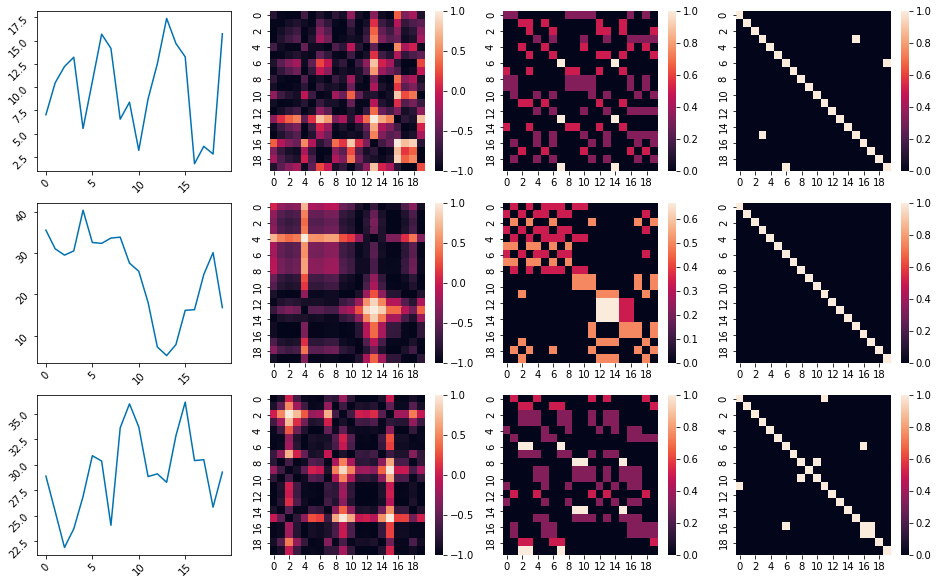

In [ ]:
import random

n, m, _, _ = X.shape

list_random = random.sample([i for i in range(0, n)], 3)

n_row = 3
fig, axes = plt.subplots(n_row, 4, figsize=(16, 10))

for i in range(0, n_row):
  ax = sns.lineplot(x=[i for i in range(0, m)], y=pre_X[list_random[i]], ax = axes[i][0])
  ax.tick_params(rotation=45)
  sns.heatmap(data = X_GAF[list_random[i]], ax = axes[i][1])
  sns.heatmap(data = X_MTF[list_random[i]], ax = axes[i][2])
  sns.heatmap(data = X_RP[list_random[i]], ax = axes[i][3])

## Plot y

### Quantiles

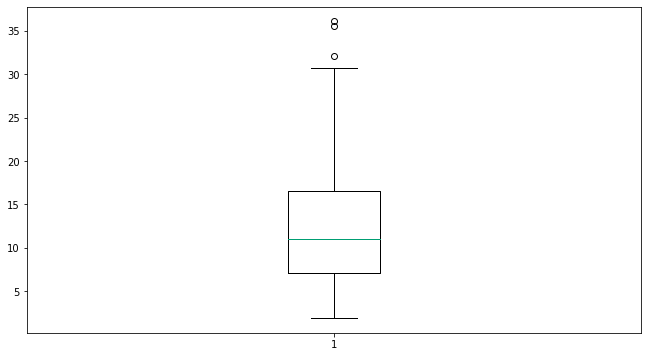

In [ ]:
def plot_quantiles(pre_y, y, i):
  data = pre_y[i, :]

  fig, ax = plt.subplots(figsize = (11, 6))

  bp = ax.boxplot(data)

  plt.show()

  return None

plot_quantiles(pre_y, y_quant, 0)

### Decil

In [ ]:
def plot_deciles(pre_y, y, i):
  data = y[i, :]
  n_bins = data.shape[0]
  bind_edges = [i*5.0 for i in range(0, n_bins + 1)]
  sample = []
  for i in range(0, n_bins):
    sample += [(bind_edges[i] + bind_edges[i + 1])/2 for j in range(0, int(y_dec[0][i]))]
  fig, ax = plt.subplots(figsize = (11, 6))
  ax.hist(sample, bins=10, range=(0.0, 50.0))
  ax.legend()
  return None

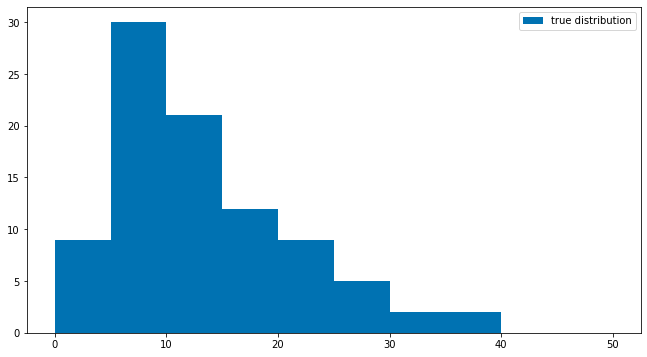

In [ ]:
plot_deciles(pre_y, y_dec, 0)

### KDE

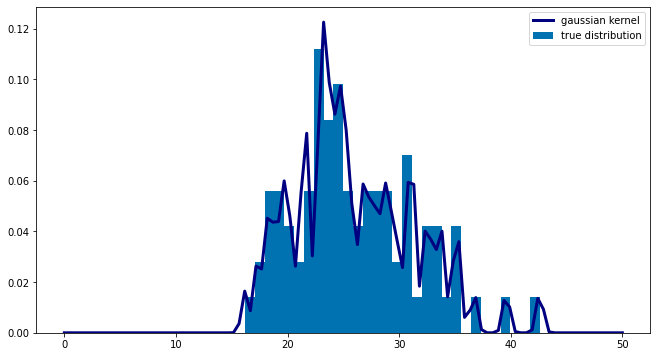

In [ ]:
def plot_dens(pre_y, y, i):
  data = y[i, :]

  X_plot = np.linspace(0, 50, 100)[:, np.newaxis]

  fig, ax = plt.subplots(figsize = (11, 6))

  ax.plot(
        X_plot[:, 0],
        data,
        color='navy',
        lw=3,
        linestyle='-',
        label= 'gaussian kernel'
    )

  ax.hist(pre_y[i, :], bins=30, density=True, label='true distribution')

  ax.legend()
  return None

plot_dens(pre_y, y_kde, -1)

### Gaussian Mixture

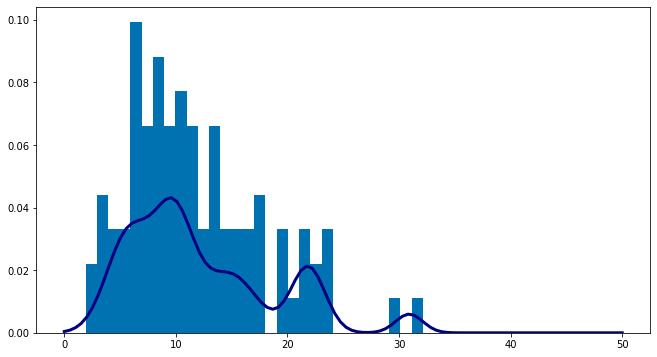

In [ ]:
def plot_gaussian_mixture(pre_y, y, i):
  weights = y[i, 0:5]
  means = y[i, 5:10]
  stds = y[i, 10:15]
  sample = pre_y[i]

  X = np.linspace(0, 50, 100)
  data = gaussian_mixture_function(weights, means, stds, X)

  fig, ax = plt.subplots(figsize = (11, 6))

  ax.plot(
        X,
        data,
        color='navy',
        lw=3,
        linestyle='-',
  )

  ax.hist(sample, bins=30, density=True)

  return None

plot_gaussian_mixture(pre_y, y_gm, 4)

# CNN

## Quantiles


### Models

In [ ]:
def get_model(input_shape, output_activation, n_neuron):
  input = Input(shape=input_shape)

  conv_1 = Conv2D(32, (3, 3), padding='same', activation="relu")(input)
  conv_2 = Conv2D(32, (3, 3), padding='same', activation="relu")(conv_1)
  maxpool_1 = MaxPool2D((2,2), padding='same')(conv_2)
  dropout_1 = Dropout(0.25)(maxpool_1)

  conv_3 = Conv2D(64, (3, 3), padding='same', activation="relu")(dropout_1)
  conv_4 = Conv2D(64, (3, 3), padding='same', activation="relu")(conv_3)
  maxpool_2 = MaxPool2D((2,2), padding='same')(conv_4)
  dropout_2 = Dropout(0.25)(maxpool_2)

  conv_5 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_2)
  conv_6 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_5)
  maxpool_3 = MaxPool2D((2,2), padding='same')(conv_6)
  dropout_3 = Dropout(0.25)(maxpool_3)

  conv_7 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_3)
  conv_8 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_7)

  globalavgpool_1 = GlobalAvgPool2D()(conv_8)
  output = Dense(n_neuron, activation=output_activation)(globalavgpool_1)
  model = Model(inputs=input, outputs=output)

  return model

In [ ]:
model_quant_1 = get_model(X.shape[1:], 'linear', 5)

In [ ]:
model_quant_2 = get_model(X.shape[1:], 'linear', 5)

In [ ]:
model_quant_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                             

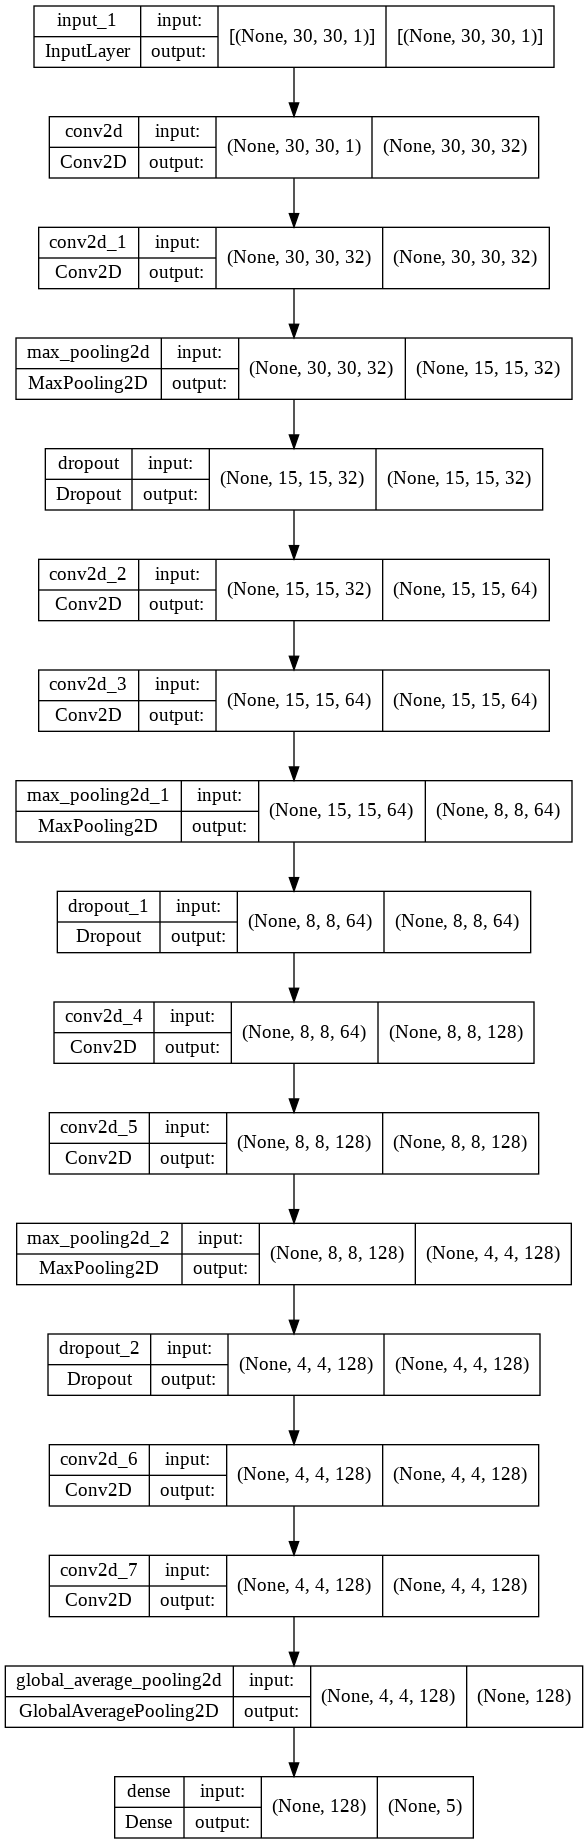

In [ ]:
plot_model(model_quant_1, to_file='model_quant_1_plot.png', show_shapes=True, show_layer_names=True)

### Split

In [ ]:
# Set de entrenamiento box plot sin normalizar
X_train, X_test, y_train, y_test = train_test_split(X, y_quant, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [ ]:
# Set de entrenamiento box plot normalizado
X_train, X_test, y_train, y_test = train_test_split(X, y_norm_quant, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

### Compile

In [ ]:
model_quant_1.compile(loss='mse', optimizer='adam')

In [ ]:
model_quant_2.compile(loss='mse', optimizer='adam')

### Training

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_quantiles_model',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history_1 = model_quant_1.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
154/154 [==============================] - 2s 16ms/step - loss: 4.0774 - val_loss: 6.3388
Epoch 2/100
154/154 [==============================] - 2s 10ms/step - loss: 4.4659 - val_loss: 9.3637
Epoch 3/100
154/154 [==============================] - 2s 11ms/step - loss: 4.0722 - val_loss: 7.4361
Epoch 4/100
154/154 [==============================] - 2s 10ms/step - loss: 4.1602 - val_loss: 7.2213
Epoch 5/100
154/154 [==============================] - 2s 11ms/step - loss: 5.2614 - val_loss: 11.3305
Epoch 6/100
154/154 [==============================] - 2s 10ms/step - loss: 4.4555 - val_loss: 11.0102
Epoch 7/100
154/154 [==============================] - 2s 10ms/step - loss: 4.0421 - val_loss: 12.0904
Epoch 8/100
154/154 [==============================] - 2s 10ms/step - loss: 3.9739 - val_loss: 7.3994
Epoch 9/100
154/154 [==============================] - 2s 11ms/step - loss: 3.6102 - val_loss: 8.2455
Epoch 10/100
154/154 [==============================] - 2s 11ms/step - loss: 4.

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_norm_quantiles_model',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history_2 = model_quant_2.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
154/154 [==============================] - 2s 11ms/step - loss: 0.0433 - val_loss: 0.0313
Epoch 2/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0283 - val_loss: 0.0277
Epoch 3/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0276 - val_loss: 0.0269
Epoch 4/100
154/154 [==============================] - 1s 6ms/step - loss: 0.0271 - val_loss: 0.0270
Epoch 5/100
154/154 [==============================] - 1s 6ms/step - loss: 0.0268 - val_loss: 0.0272
Epoch 6/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0256 - val_loss: 0.0259
Epoch 7/100
154/154 [==============================] - 1s 6ms/step - loss: 0.0254 - val_loss: 0.0267
Epoch 8/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0240 - val_loss: 0.0243
Epoch 9/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0228 - val_loss: 0.0218
Epoch 10/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0211 - val_l

### Results

In [ ]:
def plot_pred_quantiles(y_true, y_pred, n_samples, random_pick, pick_list = []):

  n = y_true.shape[0]
  if random_pick:
    pick_list = random.sample([i for i in range(0, n)], n_samples)
  else:
    if len(pick_list) != n_samples:
      return None

  n_col = 3
  n_row = int(np.ceil(n_samples / n_col))
  fig, axes = plt.subplots(n_row, n_col, figsize = (int(n_row*9), int(n_col*5)))

  for i in range(0, n_samples):
    axes_i = int(i / n_col)
    axes_j = i % n_col
    sample = [y_pred[pick_list[i]], y_true[pick_list[i]]]
    axes[axes_i][axes_j].boxplot(sample, labels=['predicted quantiles', 'true quantiles'], whis=[0, 100])
    axes[axes_i][axes_j].set_title(f'Quantiles n°{pick_list[i] + 1}')

  plt.subplots_adjust(left=0.1,
      bottom=0.1, 
      right=0.9, 
      top=0.9, 
      wspace=0.1, 
      hspace=0.3)
  
  return None

In [ ]:
model_quant_1.load_weights('/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_quantiles_model')
y_pred_1 = model_quant_1.predict(X_val)

In [ ]:
mse = mean_squared_error(y_val, y_pred_1)
print('MSE Validation:', mse)

MSE Validation: 4.099190462601358


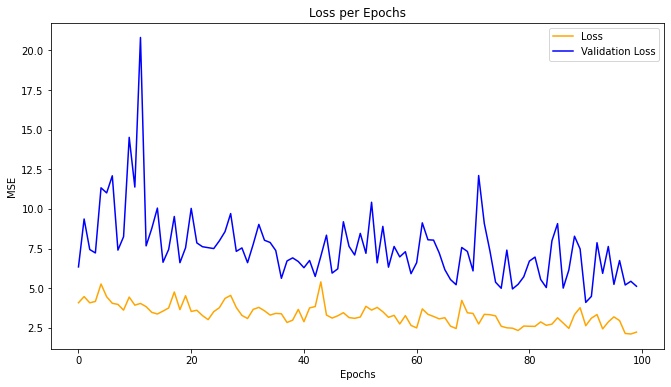

In [ ]:
n_epochs = len(history_1.history['loss'])
data = [i for i in range(0, n_epochs)]


fig, ax = plt.subplots(figsize = (11, 6))

ax.plot(data, history_1.history['loss'], color='orange', label='Loss')
ax.plot(data, history_1.history['val_loss'], color='blue', label='Validation Loss')

ax.legend()
ax.set_title('Loss per Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

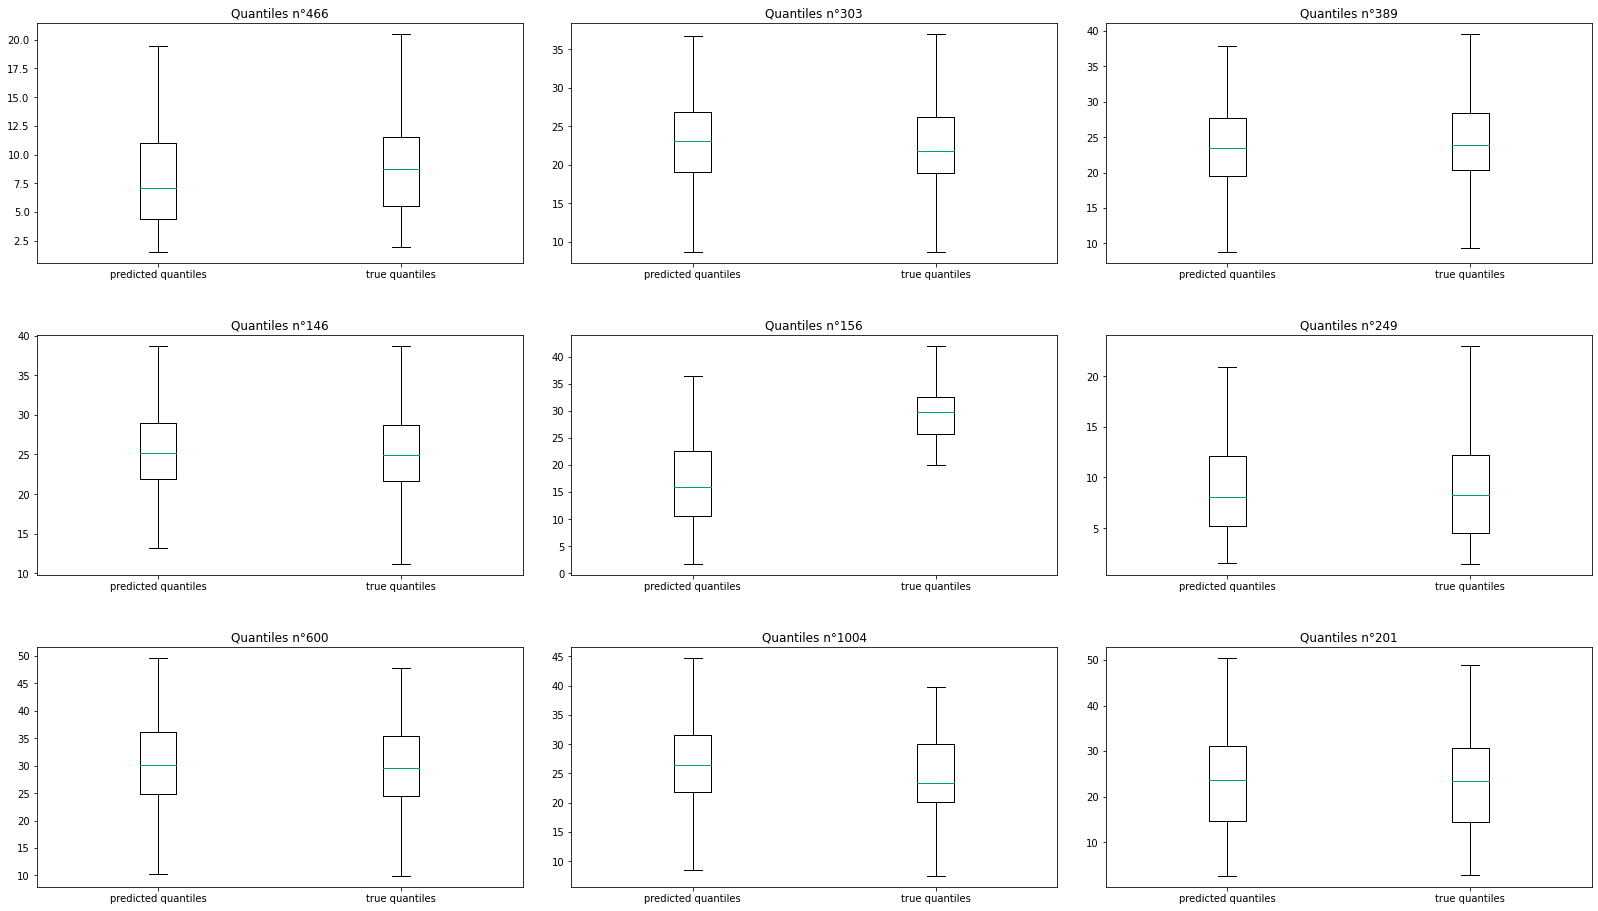

In [ ]:
n_samples = 9
plot_pred_quantiles(y_val, y_pred_1, n_samples, True)
#plot_pred_quantiles(y_val, y_pred, n_samples, False, [i for i in range(0, n_samples)])

In [ ]:
model_quant_2.load_weights('/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_norm_quantiles_model')
y_pred_2 = model_quant_2.predict(X_val)

In [ ]:
mse = mean_squared_error(y_val, y_pred_2)
print('MSE Validation:', mse)

MSE Validation: 0.002031381677101151


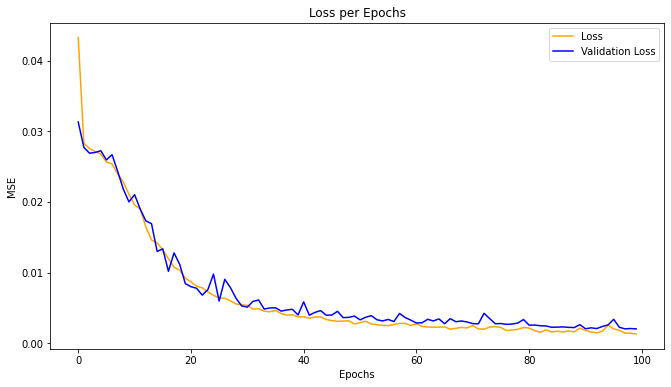

In [ ]:
n_epochs = len(history_2.history['loss'])
data = [i for i in range(0, n_epochs)]


fig, ax = plt.subplots(figsize = (11, 6))

ax.plot(data, history_2.history['loss'], color='orange', label='Loss')
ax.plot(data, history_2.history['val_loss'], color='blue', label='Validation Loss')

ax.legend()
ax.set_title('Loss per Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

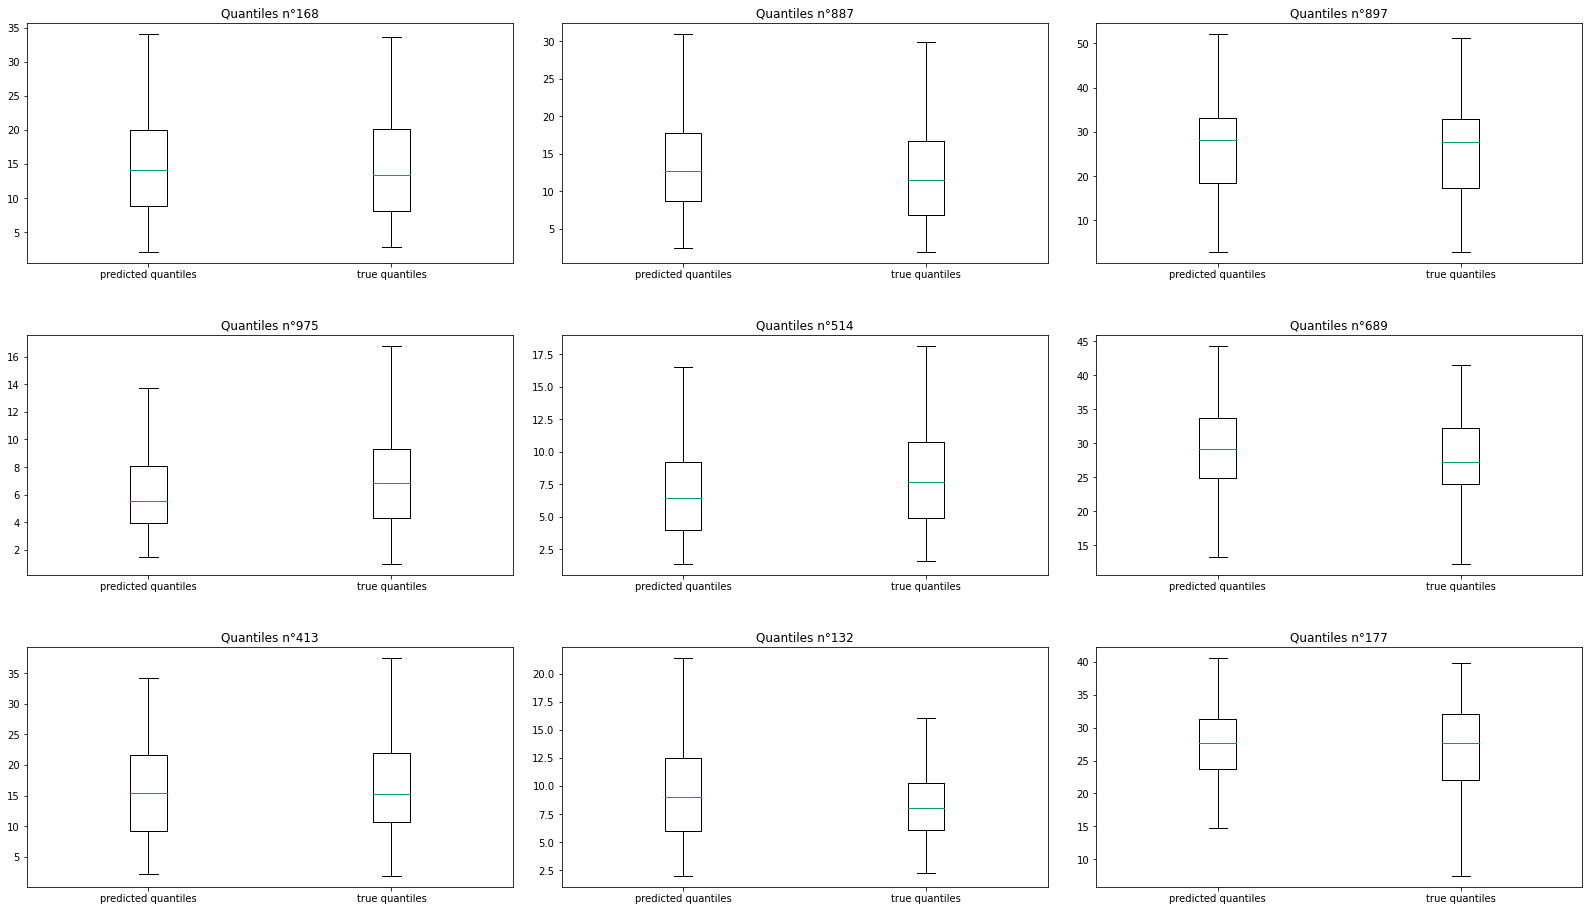

In [ ]:
n_samples = 9
plot_pred_quantiles(y_val*50., y_pred_2*50., n_samples, True)
#plot_pred_quantiles(y_val, y_pred, n_samples, False, [i for i in range(0, n_samples)])

## Densities per Bins

### Models

In [ ]:
def get_model(input_shape, output_activation, n_neuron):
  input = Input(shape=input_shape)

  conv_1 = Conv2D(32, (3, 3), padding='same', activation="relu")(input)
  conv_2 = Conv2D(32, (3, 3), padding='same', activation="relu")(conv_1)
  maxpool_1 = MaxPool2D((2,2), padding='same')(conv_2)
  dropout_1 = Dropout(0.25)(maxpool_1)

  conv_3 = Conv2D(64, (3, 3), padding='same', activation="relu")(dropout_1)
  conv_4 = Conv2D(64, (3, 3), padding='same', activation="relu")(conv_3)
  maxpool_2 = MaxPool2D((2,2), padding='same')(conv_4)
  dropout_2 = Dropout(0.25)(maxpool_2)

  conv_5 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_2)
  conv_6 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_5)
  maxpool_3 = MaxPool2D((2,2), padding='same')(conv_6)
  dropout_3 = Dropout(0.25)(maxpool_3)

  conv_7 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_3)
  conv_8 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_7)

  globalavgpool_1 = GlobalAvgPool2D()(conv_8)
  output = Dense(n_neuron, activation=output_activation)(globalavgpool_1)
  model = Model(inputs=input, outputs=output)

  return model

In [ ]:
model_dens_bins_1 = get_model(X.shape[1:], 'linear', 10)

In [ ]:
model_dens_bins_2 = get_model(X.shape[1:], 'softmax', 10)

In [ ]:
model_dens_bins_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 15, 15, 64)        18496     
                                                           

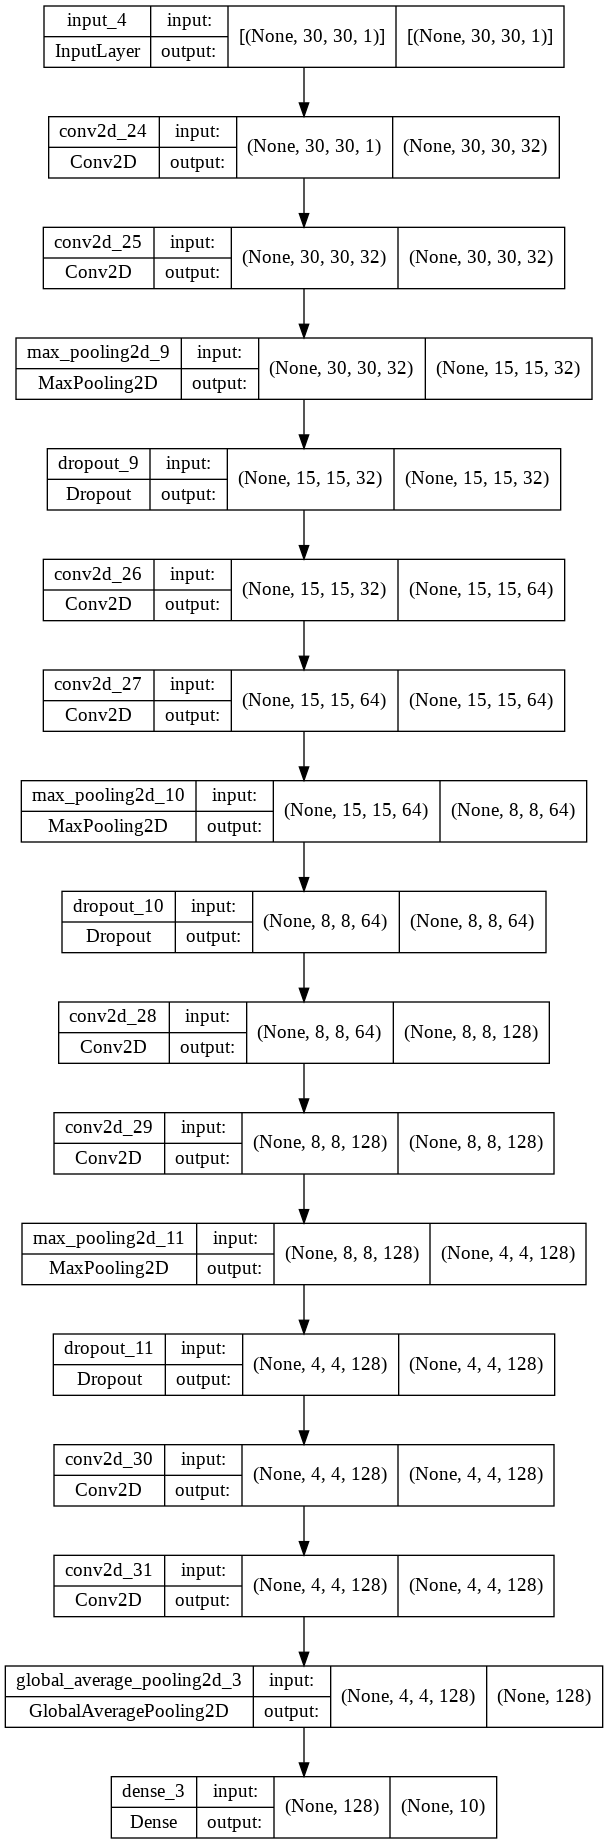

In [ ]:
plot_model(model_dens_bins_1, to_file='model_dens_decile_plot.png', show_shapes=True, show_layer_names=True)

### Split

In [ ]:
# Set de entrenamiento densidades sin normalizar
X_train, X_test, y_train, y_test = train_test_split(X, y_dens_bin, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [ ]:
# Set de entrenamiento densidades normalizado
X_train, X_test, y_train, y_test = train_test_split(X, y_dens_perc_bin, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

### Compile

In [ ]:
model_dens_bins_1.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
model_dens_bins_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

### Training

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_density_bins_model',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history_1 = model_dens_bins_1.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
154/154 [==============================] - 2s 9ms/step - loss: 82.9971 - val_loss: 81.0687
Epoch 2/100
154/154 [==============================] - 1s 7ms/step - loss: 79.8726 - val_loss: 82.4873
Epoch 3/100
154/154 [==============================] - 1s 7ms/step - loss: 79.7707 - val_loss: 79.7642
Epoch 4/100
154/154 [==============================] - 1s 7ms/step - loss: 79.4826 - val_loss: 78.7929
Epoch 5/100
154/154 [==============================] - 1s 6ms/step - loss: 79.1396 - val_loss: 79.8440
Epoch 6/100
154/154 [==============================] - 1s 7ms/step - loss: 76.5795 - val_loss: 78.4097
Epoch 7/100
154/154 [==============================] - 1s 7ms/step - loss: 73.3871 - val_loss: 73.3669
Epoch 8/100
154/154 [==============================] - 1s 7ms/step - loss: 70.5625 - val_loss: 69.3136
Epoch 9/100
154/154 [==============================] - 1s 7ms/step - loss: 66.8291 - val_loss: 68.4624
Epoch 10/100
154/154 [==============================] - 1s 7ms/step - los

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_density_percent_bins_model',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history_2 = model_dens_bins_2.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
154/154 [==============================] - 2s 9ms/step - loss: 2.1217 - val_loss: 2.1158
Epoch 2/100
154/154 [==============================] - 1s 7ms/step - loss: 2.0965 - val_loss: 2.0983
Epoch 3/100
154/154 [==============================] - 2s 12ms/step - loss: 2.0912 - val_loss: 2.0920
Epoch 4/100
154/154 [==============================] - 1s 7ms/step - loss: 2.0753 - val_loss: 2.0861
Epoch 5/100
154/154 [==============================] - 1s 7ms/step - loss: 2.0689 - val_loss: 2.0722
Epoch 6/100
154/154 [==============================] - 1s 7ms/step - loss: 2.0456 - val_loss: 2.0591
Epoch 7/100
154/154 [==============================] - 1s 6ms/step - loss: 2.0217 - val_loss: 2.0632
Epoch 8/100
154/154 [==============================] - 1s 8ms/step - loss: 2.0045 - val_loss: 2.0303
Epoch 9/100
154/154 [==============================] - 1s 7ms/step - loss: 1.9686 - val_loss: 1.9584
Epoch 10/100
154/154 [==============================] - 1s 7ms/step - loss: 1.9411 - val_l

### Results

In [ ]:
model_dens_bins_1.load_weights('/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_density_bins_model')
y_pred_1 = model_dens_bins_1.predict(X_val)

In [ ]:
def get_sample(deciles, bind_edges, n_bins):
  sample = []
  for i in range(0, n_bins):
    sample += [(bind_edges[i] + bind_edges[i + 1])/2 for j in range(0, int(deciles[i]))]
  return sample

def plot_pred_density_per_bins(y_true, y_pred, n_bins, n_samples, random_pick, pick_list = []):

  n = y_true.shape[0]
  if random_pick:
    pick_list = random.sample([i for i in range(0, n)], n_samples)
  else:
    if len(pick_list) != n_samples:
      return None

  n_col = 3
  n_row = int(np.ceil(n_samples / n_col))
  fig, axes = plt.subplots(n_row, n_col, figsize = (int(n_row*9), int(n_col*5)))

  bind_edges = [i*5.0 for i in range(0, n_bins + 1)]

  for i in range(0, n_samples):
    pred_sample = get_sample(y_pred[pick_list[i]], bind_edges, n_bins)
    true_sample = get_sample(y_true[pick_list[i]], bind_edges, n_bins)
    axes_i = int(i / n_col)
    axes_j = i % n_col
    axes[axes_i][axes_j].hist(pred_sample, bins=10, range=(0.0, 50.0), alpha = 0.5, label='predicted densities per bin', color='blue')
    axes[axes_i][axes_j].hist(true_sample, bins=10, range=(0.0, 50.0), alpha = 0.5, label='true densities per bin', color='orange')
    axes[axes_i][axes_j].set_title(f'Bins distribution n°{pick_list[i] + 1}')
    axes[axes_i][axes_j].legend()
  
  plt.subplots_adjust(left=0.1,
      bottom=0.1, 
      right=0.9, 
      top=0.9, 
      wspace=0.1, 
      hspace=0.3)
  
  return None

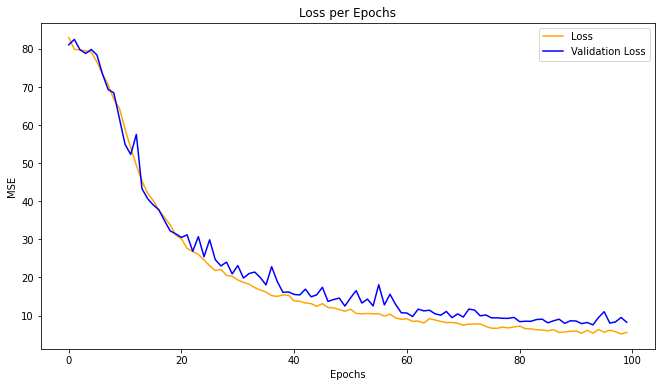

In [ ]:
_n_epochs = len(history_1.history['loss'])
data = [i for i in range(0, n_epochs)]


fig, ax = plt.subplots(figsize = (11, 6))

ax.plot(data, history_1.history['loss'], color='orange', label='Loss')
ax.plot(data, history_1.history['val_loss'], color='blue', label='Validation Loss')

ax.legend()
ax.set_title('Loss per Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

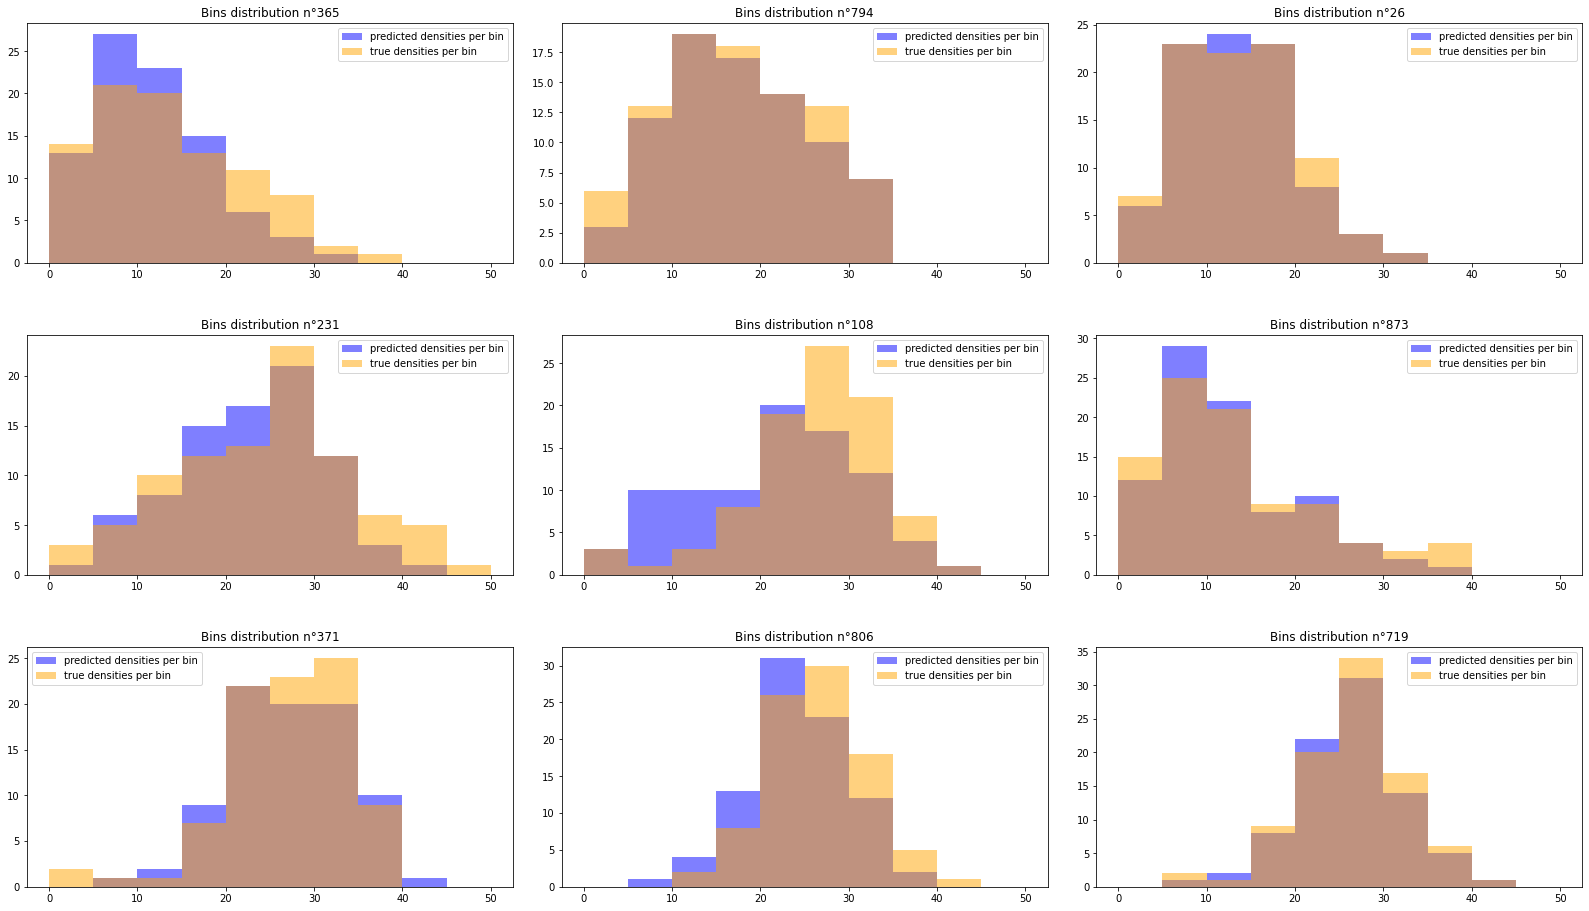

In [ ]:
n_bins = 10
n_samples = 9
plot_pred_density_per_bins(y_val, y_pred_1, n_bins, n_samples, True)
#plot_pred_density_per_bins(y_val, y_pred_1, n_bins, n_samples, False, [i for i in range(0, n_samples)])

In [ ]:
model_dens_bins_2.load_weights('/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_density_percent_bins_model')
y_pred_2 = model_dens_bins_2.predict(X_val)

In [ ]:
def get_sample_percent(bins, bind_edges, n_bins):
  sample = []
  for i in range(0, n_bins):
    sample += [(bind_edges[i] + bind_edges[i + 1])/2 for j in range(0, int(bins[i]*10000))]
  return sample

def plot_pred_density_percent_per_bins(y_true, y_pred, n_bins, n_samples, random_pick, pick_list = []):

  n = y_true.shape[0]
  if random_pick:
    pick_list = random.sample([i for i in range(0, n)], n_samples)
  else:
    if len(pick_list) != n_samples:
      return None

  n_col = 4
  fig, axes = plt.subplots(n_samples, n_col, figsize = (18, int(4.5*n_samples)))

  bind_edges = [i*5.0 for i in range(0, n_bins + 1)]


  for i in range(0, n_samples):
    pred_sample = get_sample_percent(y_pred[pick_list[i]], bind_edges, n_bins)
    true_sample = get_sample_percent(y_true[pick_list[i]], bind_edges, n_bins)

    cumsum_pred_sample = np.concatenate(([0.], np.cumsum(y_pred[pick_list[i]])))
    cumsum_true_sample = np.concatenate(([0.], np.cumsum(y_true[pick_list[i]])))

    axes[i][0].hist(pred_sample, bins=10, range=(0.0, 50.0), alpha = 1, label='predicted densities per bin', color='blue', density=True, orientation='horizontal', edgecolor='black', linewidth=1.)
    axes[i][1].hist(true_sample, bins=10, range=(0.0, 50.0), alpha = 1, label='true densities per bin', color='orange', density=True, orientation='horizontal', edgecolor='black', linewidth=1.)
    
    axes[i][2].hist(pred_sample, bins=10, range=(0.0, 50.0), alpha = 0.3, label='predicted densities per bin', color='blue', density=True, edgecolor='black', linewidth=1.)
    axes[i][2].hist(true_sample, bins=10, range=(0.0, 50.0), alpha = 0.3, label='true densities per bin', color='orange', density=True, edgecolor='black', linewidth=1.)

    axes[i][3].plot([0.1*i for i in range(0, 11)], cumsum_pred_sample, 'k--', color='blue', label='predicted')
    axes[i][3].plot([0.1*i for i in range(0, 11)], cumsum_true_sample, 'k--', color='orange', label='true')
    axes[i][3].set_title('Cumulative distribution')

    #axes[i][0].get_yaxis().set_visible(False)
    axes[i][0].yaxis.tick_right()
    #axes[i][1].get_shared_x_axes().join(axes[i][1], axes[i][0])
    axes[i][0].set_xlim(axes[i][0].get_xlim()[::-1])

    

    axes[i][0].set_title(f'Bins distribution n°{pick_list[i] + 1}')
    axes[i][0].legend()
    axes[i][1].legend()
    axes[i][2].legend()
    axes[i][3].legend()

    #axes[i][1].set_title(f'Bins distribution n°{pick_list[i] + 1}')
    #axes[i][1].legend()
  
  plt.subplots_adjust(left=0.1,
      bottom=0.1, 
      right=0.9, 
      top=0.9, 
      wspace=0.2, 
      hspace=0.2)
  
  return None

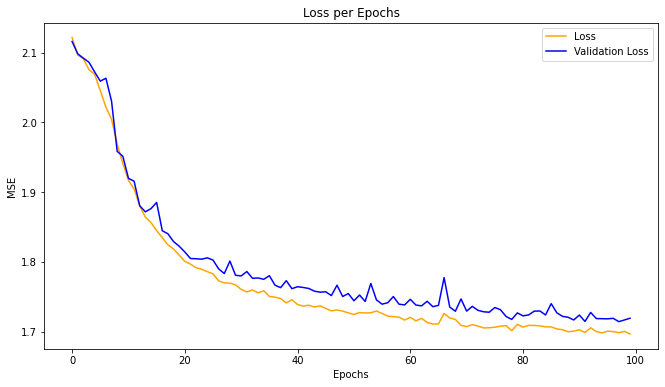

In [ ]:
n_epochs = len(history_2.history['loss'])
data = [i for i in range(0, n_epochs)]


fig, ax = plt.subplots(figsize = (11, 6))

ax.plot(data, history_2.history['loss'], color='orange', label='Loss')
ax.plot(data, history_2.history['val_loss'], color='blue', label='Validation Loss')

ax.legend()
ax.set_title('Loss per Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

In [ ]:
kl_sum = 0
ks_sum = 0
js_sum = 0
n = y_val.shape[0]

for i in range(0, n):
  pred_sample = y_pred_2[i]
  true_sample = y_val[i]
  kl_sum += np.sum(rel_entr(true_sample, pred_sample))
  ks_sum += ks_2samp(true_sample, pred_sample).pvalue
  js_sum += jensenshannon(true_sample, pred_sample)

print('KL Divergence validation:', kl_sum/n)
print('Kolmogorov-Smirnov distance validation:', ks_sum/n)
print('Jensen Shannon Divergence validation:', js_sum/n)

KL Divergence validation: 0.036046202147252675
Kolmogorov-Smirnov distance validation: 0.7732457380191146
Jensen Shannon Divergence validation: 0.08258466880843528


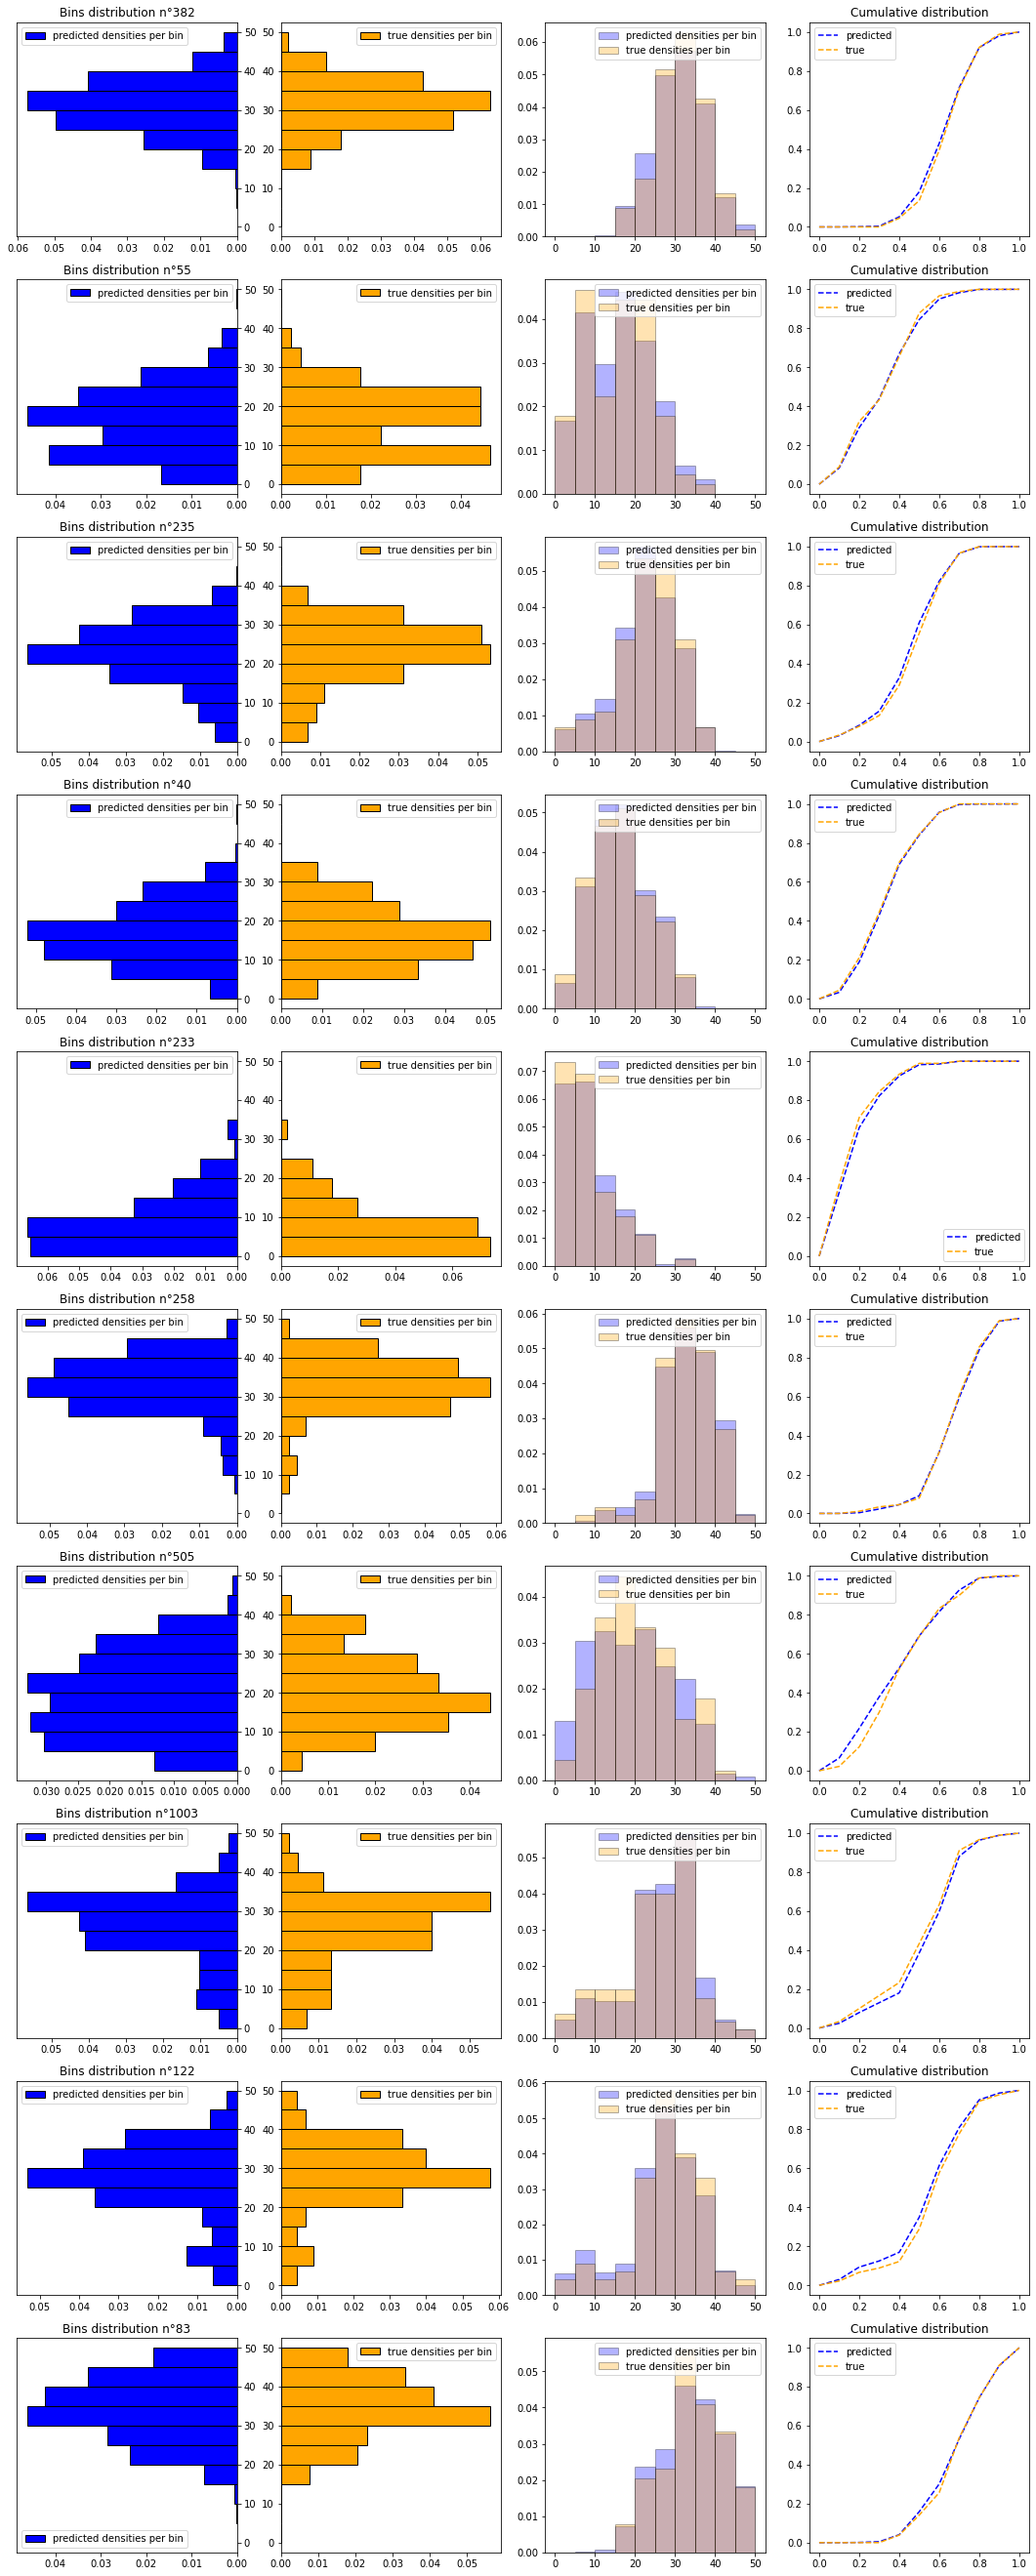

In [ ]:
n_bins = 10
n_samples = 10
plot_pred_density_percent_per_bins(y_val, y_pred_2, n_bins, n_samples, True)
#plot_pred_density_percent_per_bins(y_val, y_pred_2, n_bins, n_samples, False, [i for i in range(0, n_samples)])

## Deciles

### Models

In [ ]:
def get_model(input_shape, output_activation, n_neuron):
  input = Input(shape=input_shape)

  conv_1 = Conv2D(32, (3, 3), padding='same', activation="relu")(input)
  conv_2 = Conv2D(32, (3, 3), padding='same', activation="relu")(conv_1)
  maxpool_1 = MaxPool2D((2,2), padding='same')(conv_2)
  dropout_1 = Dropout(0.25)(maxpool_1)

  conv_3 = Conv2D(64, (3, 3), padding='same', activation="relu")(dropout_1)
  conv_4 = Conv2D(64, (3, 3), padding='same', activation="relu")(conv_3)
  maxpool_2 = MaxPool2D((2,2), padding='same')(conv_4)
  dropout_2 = Dropout(0.25)(maxpool_2)

  conv_5 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_2)
  conv_6 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_5)
  maxpool_3 = MaxPool2D((2,2), padding='same')(conv_6)
  dropout_3 = Dropout(0.25)(maxpool_3)

  conv_7 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_3)
  conv_8 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_7)

  globalavgpool_1 = GlobalAvgPool2D()(conv_8)
  output = Dense(n_neuron, activation=output_activation)(globalavgpool_1)
  model = Model(inputs=input, outputs=output)

  return model

In [ ]:
model_decile_1 = get_model(X.shape[1:], 'linear', 11)

In [ ]:
model_decile_2 = get_model(X.shape[1:], 'linear', 11)

In [ ]:
model_decile_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 30, 1)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 15, 15, 64)        18496     
                                                           

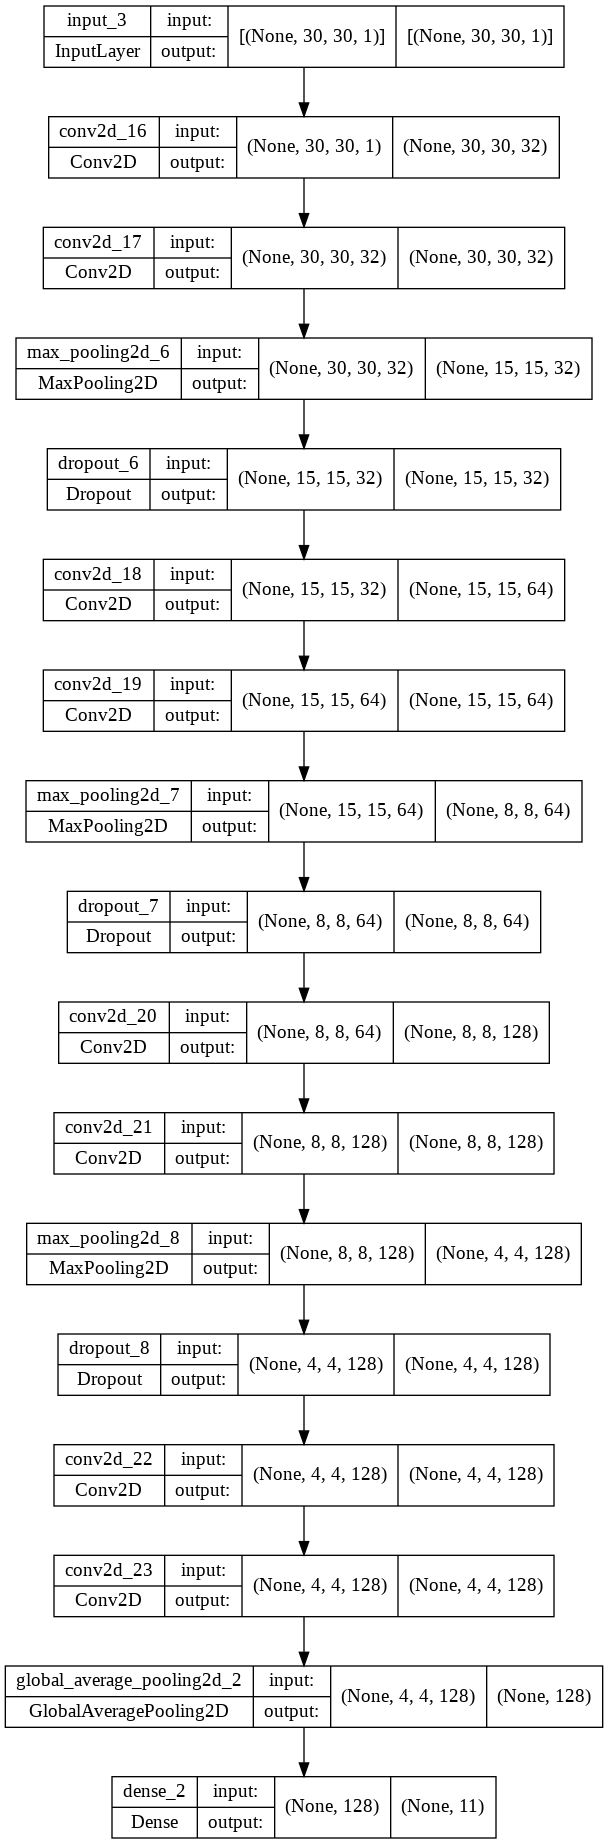

In [ ]:
plot_model(model_decile_1, to_file='model_decile_plot.png', show_shapes=True, show_layer_names=True)

### Split

In [ ]:
# Set de entrenamiento deciles
X_train, X_test, y_train, y_test = train_test_split(X, y_dec, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [ ]:
# Set de entrenamiento deciles normalizado
X_train, X_test, y_train, y_test = train_test_split(X, y_norm_dec, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [ ]:
X_train.shape, y_test.shape, y_val.shape

((4920, 30, 30, 1), (1054, 11), (1055, 11))

### Compile

In [ ]:
model_decile_1.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
model_decile_2.compile(loss = 'mse', optimizer = 'adam')

### Training

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_decile_model',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history_1 = model_decile_1.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
154/154 [==============================] - 2s 9ms/step - loss: 107.3220 - val_loss: 87.6294
Epoch 2/100
154/154 [==============================] - 1s 8ms/step - loss: 69.6264 - val_loss: 72.1318
Epoch 3/100
154/154 [==============================] - 1s 8ms/step - loss: 67.9549 - val_loss: 69.3099
Epoch 4/100
154/154 [==============================] - 1s 7ms/step - loss: 67.1851 - val_loss: 93.6991
Epoch 5/100
154/154 [==============================] - 2s 10ms/step - loss: 64.8781 - val_loss: 85.6787
Epoch 6/100
154/154 [==============================] - 2s 11ms/step - loss: 63.2701 - val_loss: 80.1591
Epoch 7/100
154/154 [==============================] - 2s 11ms/step - loss: 60.5801 - val_loss: 57.4399
Epoch 8/100
154/154 [==============================] - 2s 10ms/step - loss: 59.3999 - val_loss: 81.6754
Epoch 9/100
154/154 [==============================] - 2s 11ms/step - loss: 54.3126 - val_loss: 55.8490
Epoch 10/100
154/154 [==============================] - 2s 11ms/ste

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_norm_decile_model',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history_2 = model_decile_2.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
154/154 [==============================] - 2s 8ms/step - loss: 0.0532 - val_loss: 0.0313
Epoch 2/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0269 - val_loss: 0.0263
Epoch 3/100
154/154 [==============================] - 1s 8ms/step - loss: 0.0259 - val_loss: 0.0261
Epoch 4/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0256 - val_loss: 0.0258
Epoch 5/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0252 - val_loss: 0.0294
Epoch 6/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0247 - val_loss: 0.0263
Epoch 7/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0237 - val_loss: 0.0233
Epoch 8/100
154/154 [==============================] - 1s 7ms/step - loss: 0.0233 - val_loss: 0.0242
Epoch 9/100
154/154 [==============================] - 1s 8ms/step - loss: 0.0221 - val_loss: 0.0210
Epoch 10/100
154/154 [==============================] - 1s 9ms/step - loss: 0.0197 - val_lo






























### Results

In [ ]:
model_decile_1.load_weights('/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_decile_model')
y_pred_1 = model_decile_1.predict(X_val)

In [ ]:
def plot_pred_deciles(y_true, y_pred, n_bins, n_samples, random_pick, pick_list = []):

  n = y_true.shape[0]
  if random_pick:
    pick_list = random.sample([i for i in range(0, n)], n_samples)
  else:
    if len(pick_list) != n_samples:
      return None

  n_col = 3
  n_row = int(np.ceil(n_samples / n_col))
  fig, axes = plt.subplots(n_row, n_col, figsize = (int(n_row*9), int(n_col*5)))

  deciles_i = 1. / n_bins
  prob_deciles = [i*deciles_i for i in range(0, n_bins + 1)]

  for i in range(0, n_samples):
    axes_i = int(i / n_col)
    axes_j = i % n_col
    axes[axes_i][axes_j].plot(y_pred[pick_list[i]], prob_deciles, label='predicted deciles', color='blue')
    axes[axes_i][axes_j].plot(y_true[pick_list[i]], prob_deciles, label='true deciles', color='orange')
    axes[axes_i][axes_j].set_title(f'Deciles n°{pick_list[i] + 1}')
    axes[axes_i][axes_j].legend()
  
  plt.subplots_adjust(left=0.1,
      bottom=0.1, 
      right=0.9, 
      top=0.9, 
      wspace=0.1, 
      hspace=0.3)
  
  return None

In [ ]:
mse = mean_squared_error(y_val, y_pred_1)
print('MSE Validation:', mse)

MSE Validation: 7.01468651813288


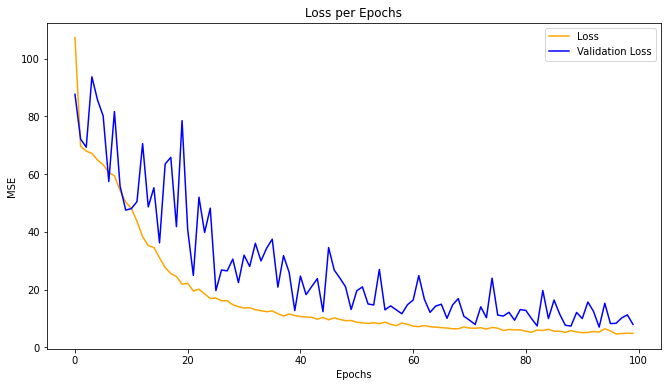

In [ ]:
n_epochs = len(history_1.history['loss'])
data = [i for i in range(0, n_epochs)]


fig, ax = plt.subplots(figsize = (11, 6))

ax.plot(data, history_1.history['loss'], color='orange', label='Loss')
ax.plot(data, history_1.history['val_loss'], color='blue', label='Validation Loss')

ax.legend()
ax.set_title('Loss per Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

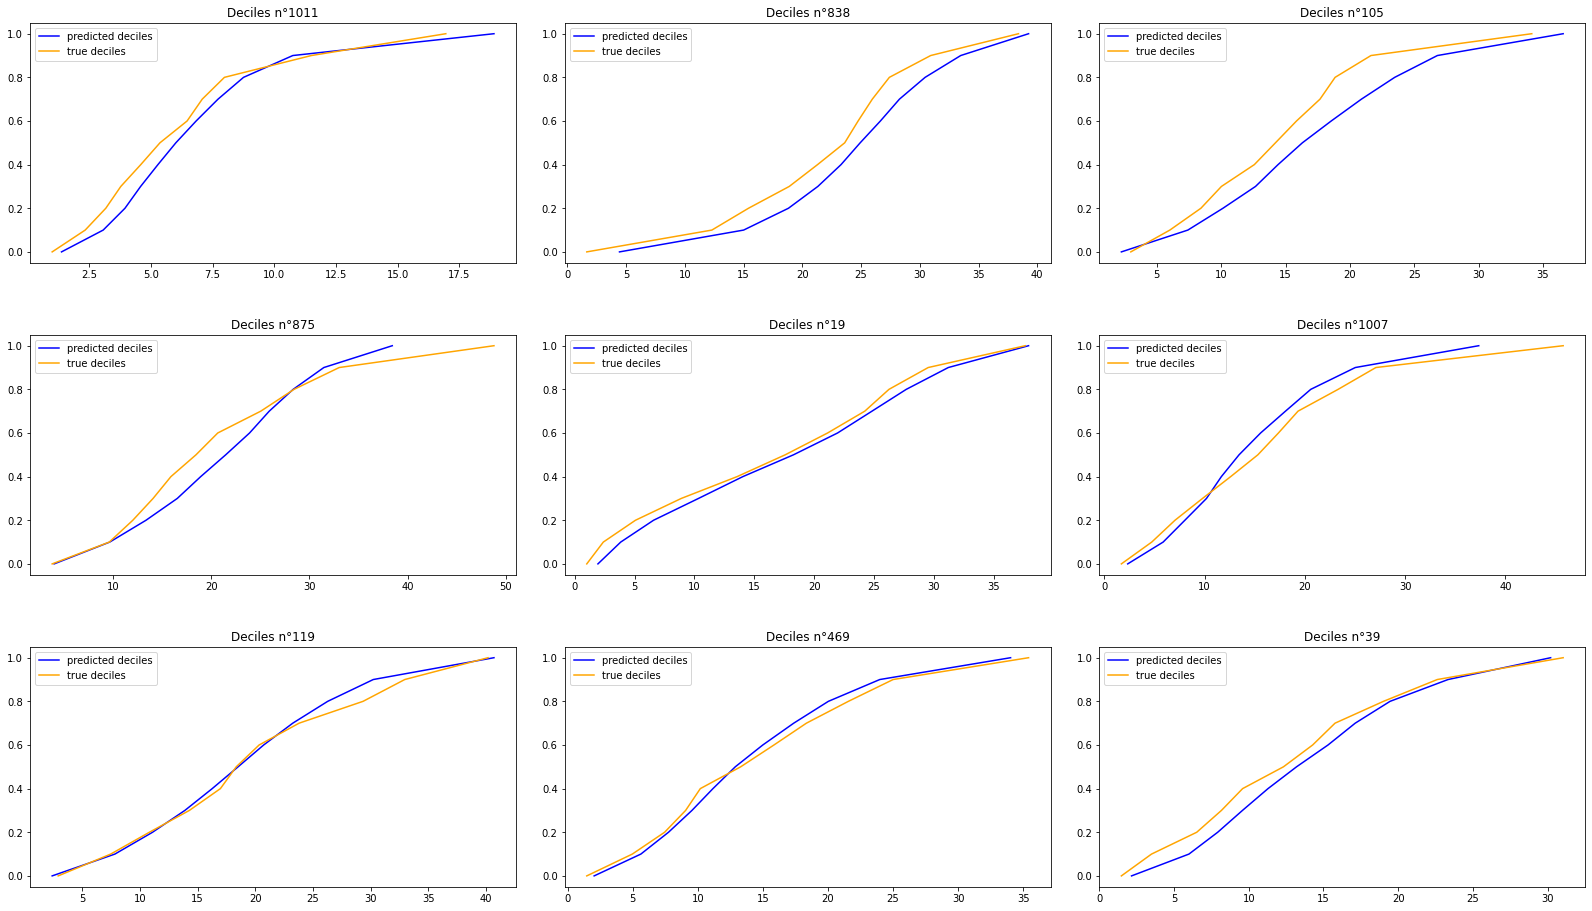

In [ ]:
n_bins = 10
n_samples = 9
plot_pred_deciles(y_val, y_pred_1, n_bins, n_samples, True)
#plot_pred_deciles(y_val, y_pred_1, n_bins, n_samples, False, [i for i in range(0, n_samples)])

In [ ]:
model_decile_2.load_weights('/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_norm_decile_model')
y_pred_2 = model_decile_2.predict(X_val)

In [ ]:
mse = mean_squared_error(50.*y_val, 50.*y_pred_2)
rmse = mean_squared_error(50.*y_val, 50.*y_pred_2, squared=False)
print('MSE Validation:', mse)
print('RMSE Validation:', rmse)

MSE Validation: 5.203286985452928
RMSE Validation: 2.238437874323461


In [ ]:
n_epochs = len(history_2.history['loss'])
data = [i for i in range(0, n_epochs)]


fig, ax = plt.subplots(figsize = (11, 6))

ax.plot(data, history_2.history['loss'], color='orange', label='Loss')
ax.plot(data, history_2.history['val_loss'], color='blue', label='Validation Loss')

ax.legend()
ax.set_title('Loss per Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()

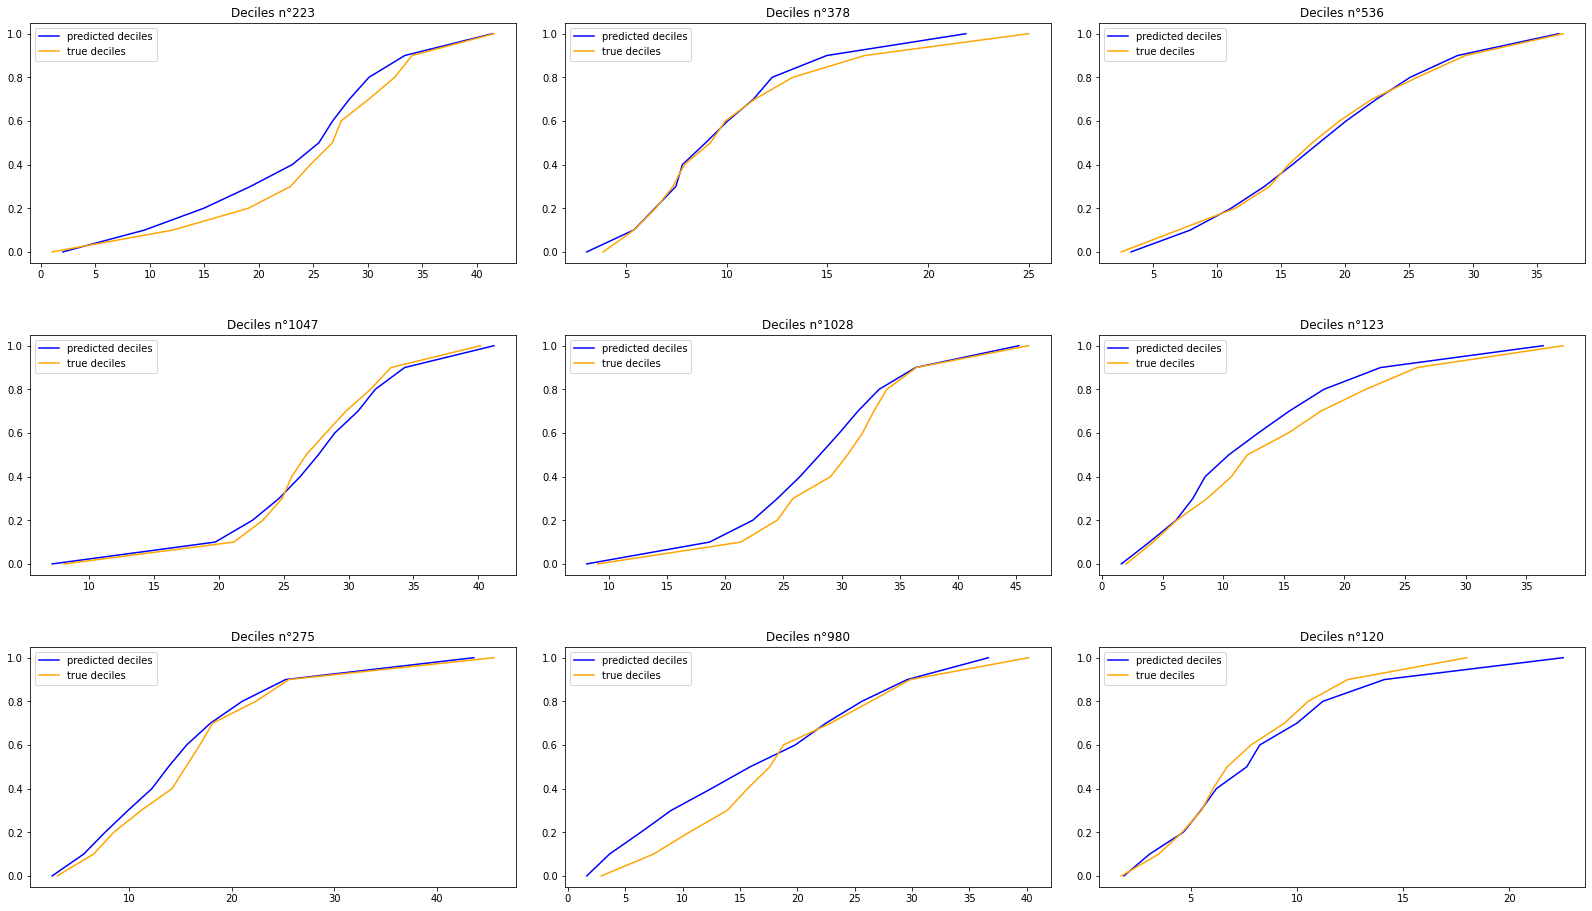

In [ ]:
n_bins = 10
n_samples = 9
plot_pred_deciles(50.*y_val, 50.*y_pred_2, n_bins, n_samples, True)
#plot_pred_deciles(50.*y_val, 50.*y_pred_2, n_bins, n_samples, False, [i for i in range(0, n_samples)])

## Gaussian Mixture


### Models

In [36]:
def nnelu(input):
  #Calculate non-negative ELU
  return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def get_custom_model(input_shape):
  input = Input(shape=input_shape)

  conv_1 = Conv2D(32, (3, 3), padding='same', activation="relu")(input)
  conv_2 = Conv2D(32, (3, 3), padding='same', activation="relu")(conv_1)
  maxpool_1 = MaxPool2D((2,2), padding='same')(conv_2)
  dropout_1 = Dropout(0.25)(maxpool_1)

  conv_3 = Conv2D(64, (3, 3), padding='same', activation="relu")(dropout_1)
  conv_4 = Conv2D(64, (3, 3), padding='same', activation="relu")(conv_3)
  maxpool_2 = MaxPool2D((2,2), padding='same')(conv_4)
  dropout_2 = Dropout(0.25)(maxpool_2)

  conv_5 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_2)
  conv_6 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_5)
  maxpool_3 = MaxPool2D((2,2), padding='same')(conv_6)
  dropout_3 = Dropout(0.25)(maxpool_3)

  conv_7 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_3)
  conv_8 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_7)

  globalavgpool_1 = GlobalAvgPool2D()(conv_8)

  output_alpha = Dense(5, activation='softmax')(globalavgpool_1)
  output_mu = Dense(5, activation='nnelu')(globalavgpool_1)
  output_sigma = Dense(5, activation='nnelu')(globalavgpool_1)

  output_concat = Concatenate(axis=1)([output_mu, output_sigma, output_alpha])
  #output_norm = BatchNormalization()(output_concat)

  model = Model(inputs=input, outputs=output_concat)

  return model

#Add activation function to keras
tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

In [ ]:
model_gm = get_custom_model(X.shape[1:])

In [41]:
model_gm = get_custom_model(X.shape[1:])

### Plot models

In [ ]:
model_gm.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 30, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 30, 30, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 30, 30, 32)   9248        ['conv2d_8[0][0]']               
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 15, 15, 32)  0           ['conv2d_9[0][0]']               
                                                                                            

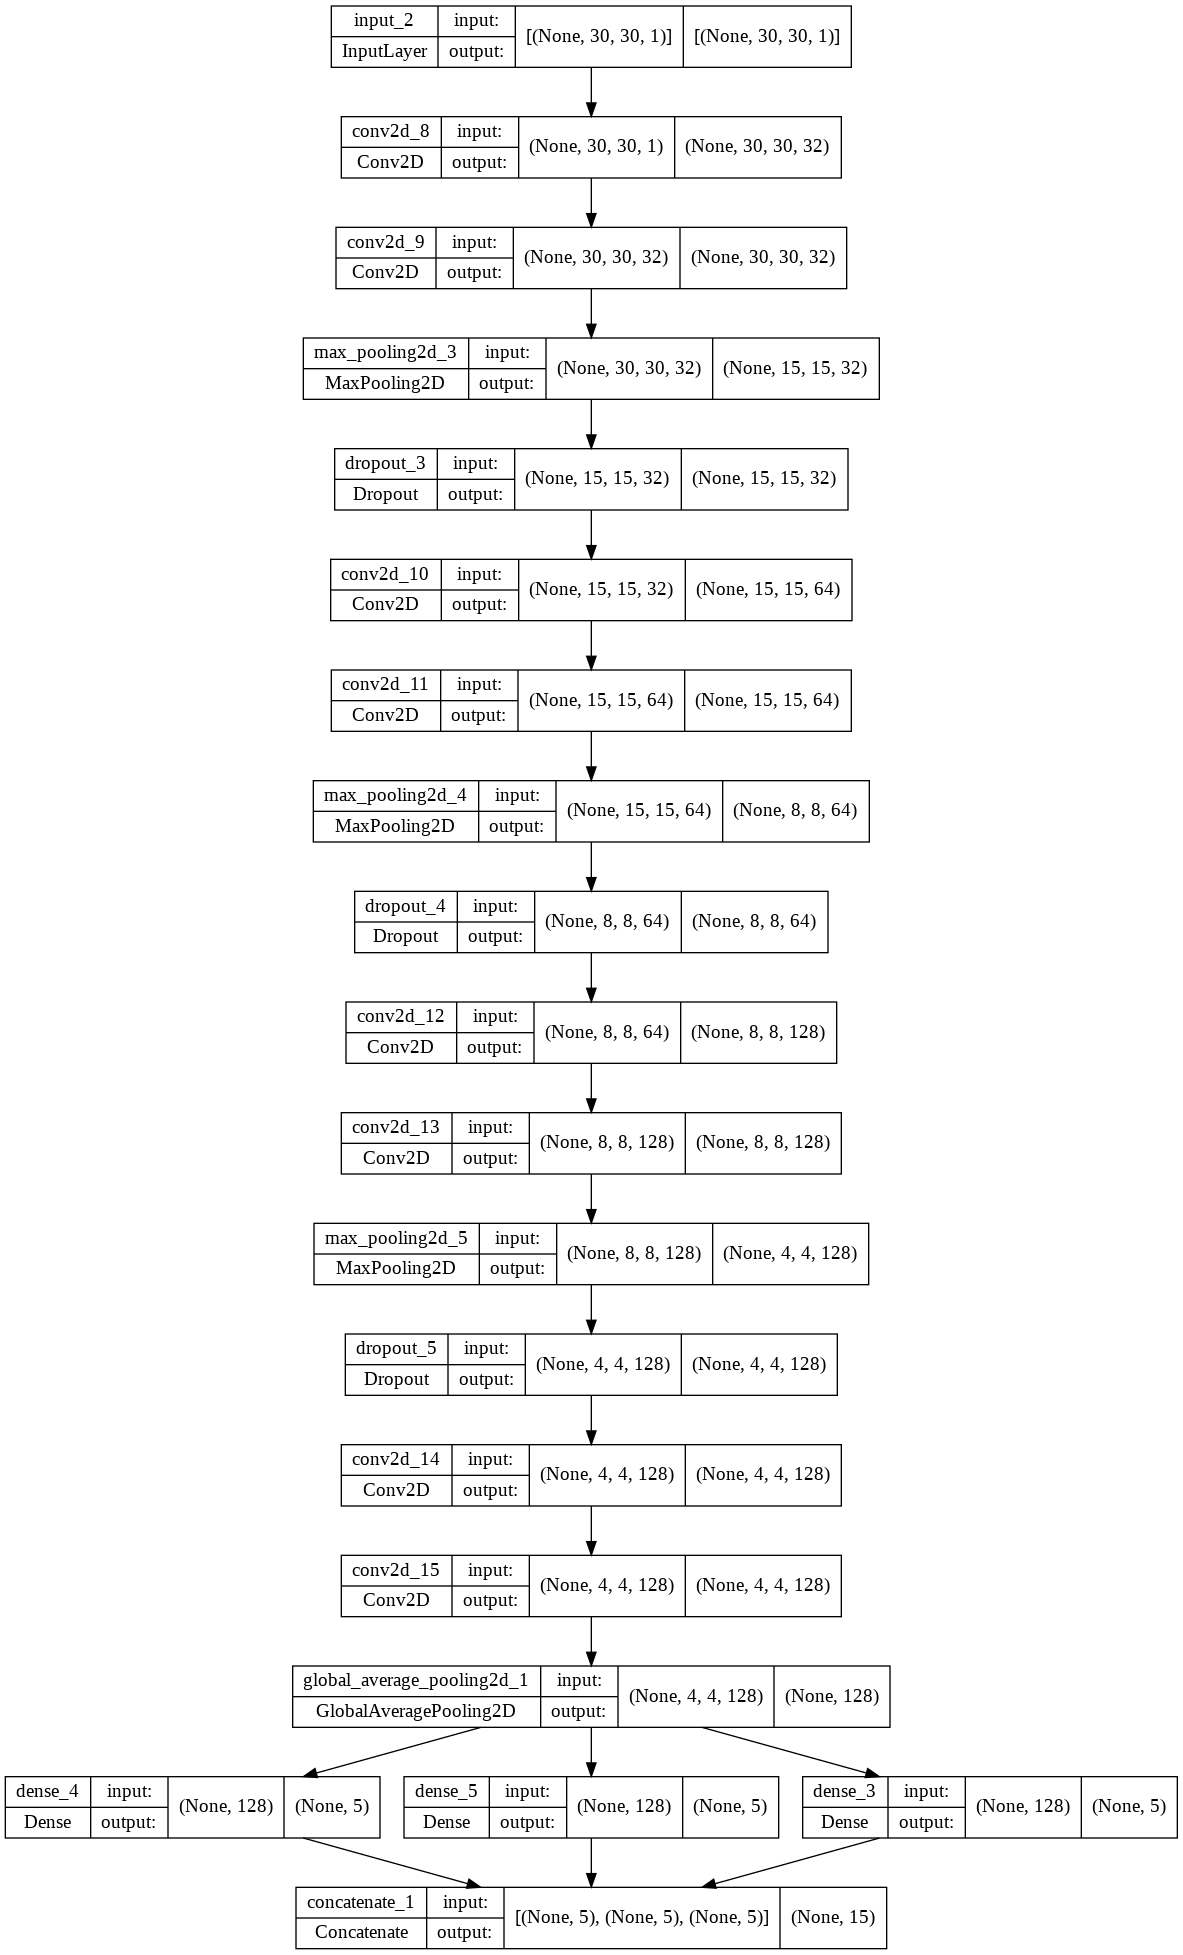

In [ ]:
plot_model(model_gm, to_file='model_gm_1_plot.png', show_shapes=True, show_layer_names=True)

### Split

In [ ]:
for pre_y_i in pre_y:
  if pre_y_i[np.isnan(pre_y_i)].shape[0] != 0:
    pre_y_i[np.isnan(pre_y_i)] = 0.

X_train, X_test, y_train, y_test = train_test_split(X, pre_y, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_gm, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_gmd, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

### Compile

In [ ]:
def log_sum_exp(x, axis=None):
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), axis=axis, keepdims=True)) + x_max

def mean_log_Gaussian_like(y_true, parameters):

    components = K.reshape(parameters, [-1, 3, 5])
    
    mu = components[:, :1, :]
    sigma = components[:, 1, :]
    alpha = components[:, 2, :]
    alpha = K.softmax(K.clip(alpha, 1e-8, 1.))

    exponent = K.log(alpha) - K.log(sigma) - 0.5*(K.log(2 * np.pi)) - K.sum((K.expand_dims(y_true, 2) - mu)**2, axis=1)/(2*(sigma)**2)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res

In [ ]:
model_gm.compile(loss = mean_log_Gaussian_like, optimizer = 'adam')

In [42]:
#kl = tf.keras.losses.KLDivergence()
model_gm.compile(loss = 'mse', optimizer = 'adam')

### Training

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_gaussian_mixture',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [ ]:
history = model_gm.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
154/154 [==============================] - 54s 343ms/step - loss: 2.6770 - val_loss: 2.2892
Epoch 2/100
154/154 [==============================] - 47s 305ms/step - loss: 2.1569 - val_loss: 2.1679
Epoch 3/100
154/154 [==============================] - 47s 306ms/step - loss: 2.1518 - val_loss: 2.1870
Epoch 4/100
154/154 [==============================] - 48s 311ms/step - loss: 2.1418 - val_loss: 2.1398
Epoch 5/100
154/154 [==============================] - 50s 323ms/step - loss: 2.1375 - val_loss: 2.1906
Epoch 6/100
154/154 [==============================] - 47s 305ms/step - loss: 2.1344 - val_loss: 2.1377
Epoch 7/100
154/154 [==============================] - 48s 315ms/step - loss: 2.1064 - val_loss: 2.1022
Epoch 8/100
154/154 [==============================] - 45s 295ms/step - loss: 2.0944 - val_loss: 2.1233
Epoch 9/100
154/154 [==============================] - 51s 330ms/step - loss: 2.0637 - val_loss: 2.1252
Epoch 10/100
154/154 [==============================] - 46s 299m

In [43]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_gaussian_mixture_test',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [44]:
history = model_gm.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])

Epoch 1/100
154/154 [==============================] - 52s 324ms/step - loss: 0.0440 - val_loss: 0.0379
Epoch 2/100
154/154 [==============================] - 52s 339ms/step - loss: 0.0350 - val_loss: 0.0393
Epoch 3/100
154/154 [==============================] - 48s 313ms/step - loss: 0.0348 - val_loss: 0.0353
Epoch 4/100
154/154 [==============================] - 47s 308ms/step - loss: 0.0347 - val_loss: 0.0357
Epoch 5/100
154/154 [==============================] - 48s 313ms/step - loss: 0.0346 - val_loss: 0.0348
Epoch 6/100
154/154 [==============================] - 50s 323ms/step - loss: 0.0344 - val_loss: 0.0358
Epoch 7/100
154/154 [==============================] - 51s 332ms/step - loss: 0.0340 - val_loss: 0.0342
Epoch 8/100
154/154 [==============================] - 50s 324ms/step - loss: 0.0338 - val_loss: 0.0340
Epoch 9/100
154/154 [==============================] - 49s 319ms/step - loss: 0.0334 - val_loss: 0.0338
Epoch 10/100
154/154 [==============================] - 51s 329m

### Results

In [ ]:
model_gm.load_weights('/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_gaussian_mixture')
y_pred = model_gm.predict(X_val)

In [45]:
model_gm.load_weights('/content/drive/My Drive/Colab Notebooks/TT/saves/checkpoint_gaussian_mixture_test')
y_pred = model_gm.predict(X_val)

In [46]:
SQRT_2PI = np.sqrt(2 * np.pi)

def normal_distribution(mean, std, X):
  # a * e ^ (b)
  a = 1 / (std * SQRT_2PI)
  b = - (np.power((X - mean), 2)) / (2 * std)
  return a * np.exp(b)

def gaussian_mixture_function(weights, means, stds, X):
  return np.sum([weight * normal_distribution(mean, std, X) for weight, mean, std in zip(weights, means, stds)], axis=0)

def get_distribution_gm(y_i, data):

  means = y_i[0:5]*50.
  stds = np.power(y_i[5:10]*50., 0.5)
  weights = y_i[10:15]
  
  return gaussian_mixture_function(weights, means, stds, data)

def plot_pred_gaussian_mixture(y_true, y_pred, n_bins, n_samples, random_pick, pick_list = []):

  n = y_true.shape[0]
  if random_pick:
    pick_list = random.sample([i for i in range(0, n)], n_samples)
  else:
    if len(pick_list) != n_samples:
      return None

  X = np.linspace(0, 50, 100)

  n_col = 3
  n_row = int(np.ceil(n_samples / n_col))
  fig, axes = plt.subplots(n_row, n_col, figsize = (int(n_row*9), int(n_col*5)))

  for i in range(0, n_samples):
    pred_sample = get_distribution_gm(y_pred[pick_list[i]], X)
    true_sample = y_true[pick_list[i]]

    axes_i = int(i / n_col)
    axes_j = i % n_col

    axes[axes_i][axes_j].plot(X, pred_sample, label='predicted gaussian mixture', color='blue')
    axes[axes_i][axes_j].hist(true_sample, density=True, bins="fd", label='true gaussian mixture', color='orange')
    axes[axes_i][axes_j].set_title(f'Gaussian Mixture distribution n°{pick_list[i] + 1}')
    axes[axes_i][axes_j].legend()
  
  plt.subplots_adjust(left=0.1,
      bottom=0.1, 
      right=0.9, 
      top=0.9, 
      wspace=0.1, 
      hspace=0.3)
  
  return None

def get_metrics_model(model, X, y_true):
  y_pred = model.predict(X)

  kl_sum = 0
  ks_sum = 0
  js_sum = 0
  bc_sum = 0

  n = y_val.shape[0]

  for i in range(0, n):
    pred_sample = y_pred[i]
    true_sample = y_val[i]
    kl_sum += np.sum(rel_entr(true_sample, pred_sample))
    ks_sum += ks_2samp(true_sample, pred_sample).pvalue
    js_sum += jensenshannon(true_sample, pred_sample)
    bc_sum += bhattacharyya_distance(true_sample, pred_sample)

  #print('Kullback–Leibler Divergence validation:', kl_sum/n)
  #print('Kolmogorov-Smirnov distance validation:', ks_sum/n)
  #print('Jensen Shannon Divergence validation:', 1 - js_sum/n)
  #print('Bhattacharyya distance validation:', bc_sum/n)
  
  return kl_sum/n, bc_sum/n, ks_sum/n, 1 - js_sum/n

Resultados modelo Gaussian Mixture con Loss *Log Gaussian Likelihood*

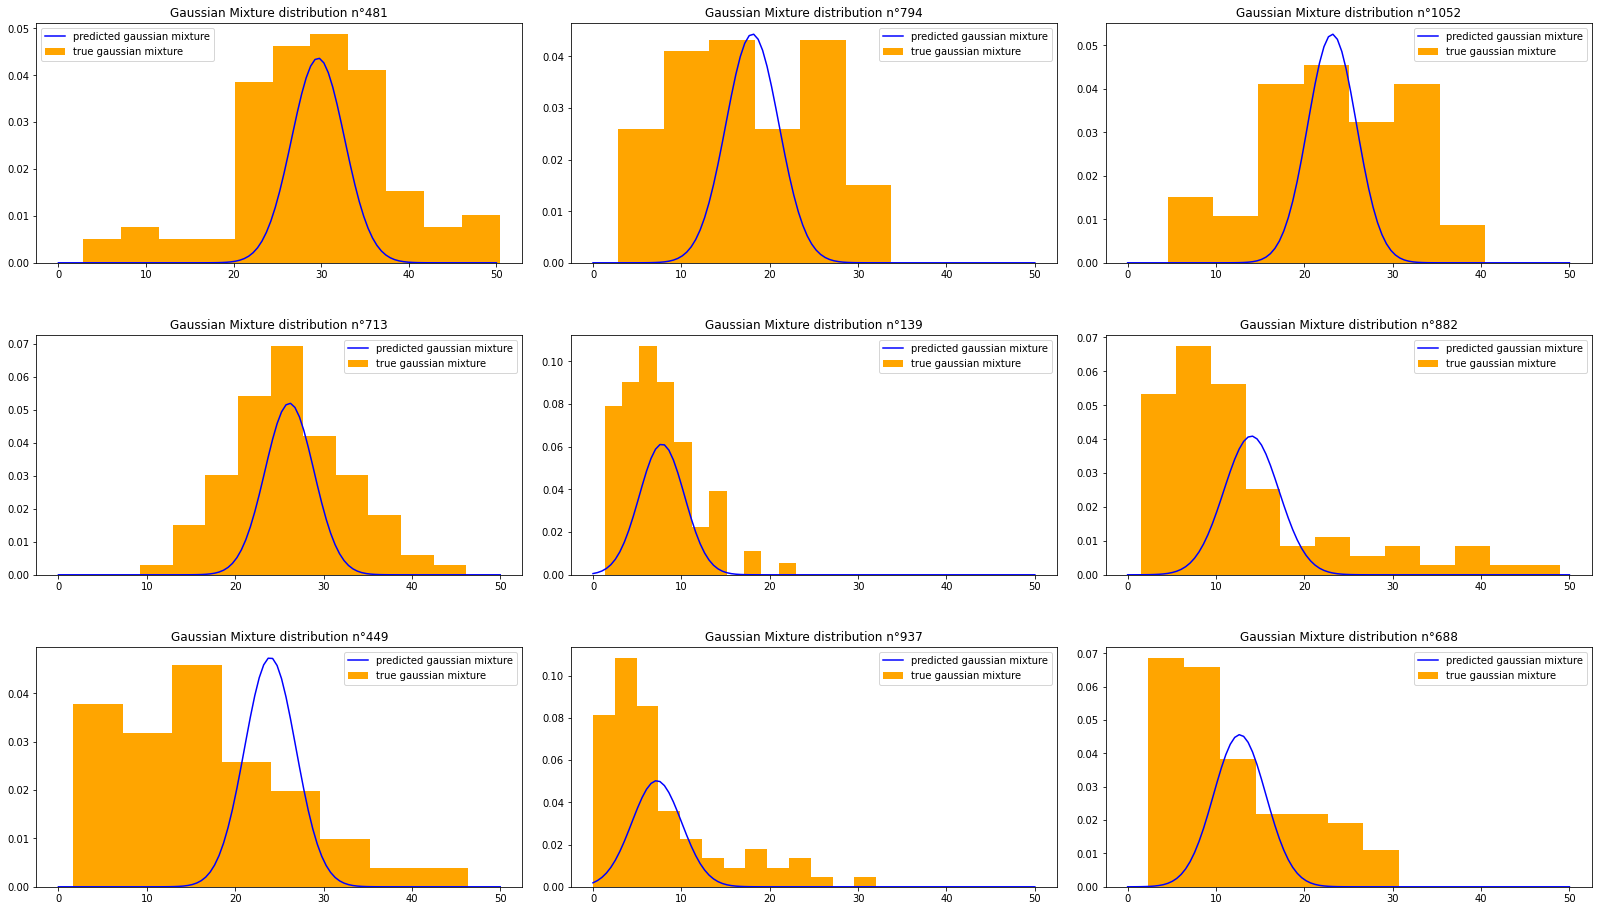

In [ ]:
n_bins = 10
n_samples = 9
plot_pred_gaussian_mixture(y_val*50., y_pred, n_bins, n_samples, True)
#plot_pred_gaussian_mixture(y_val, y_pred_1, n_bins, n_samples, False, [i for i in range(0, n_samples)])

Resultados modelo Gaussian Mixture con Loss *Mean square error*

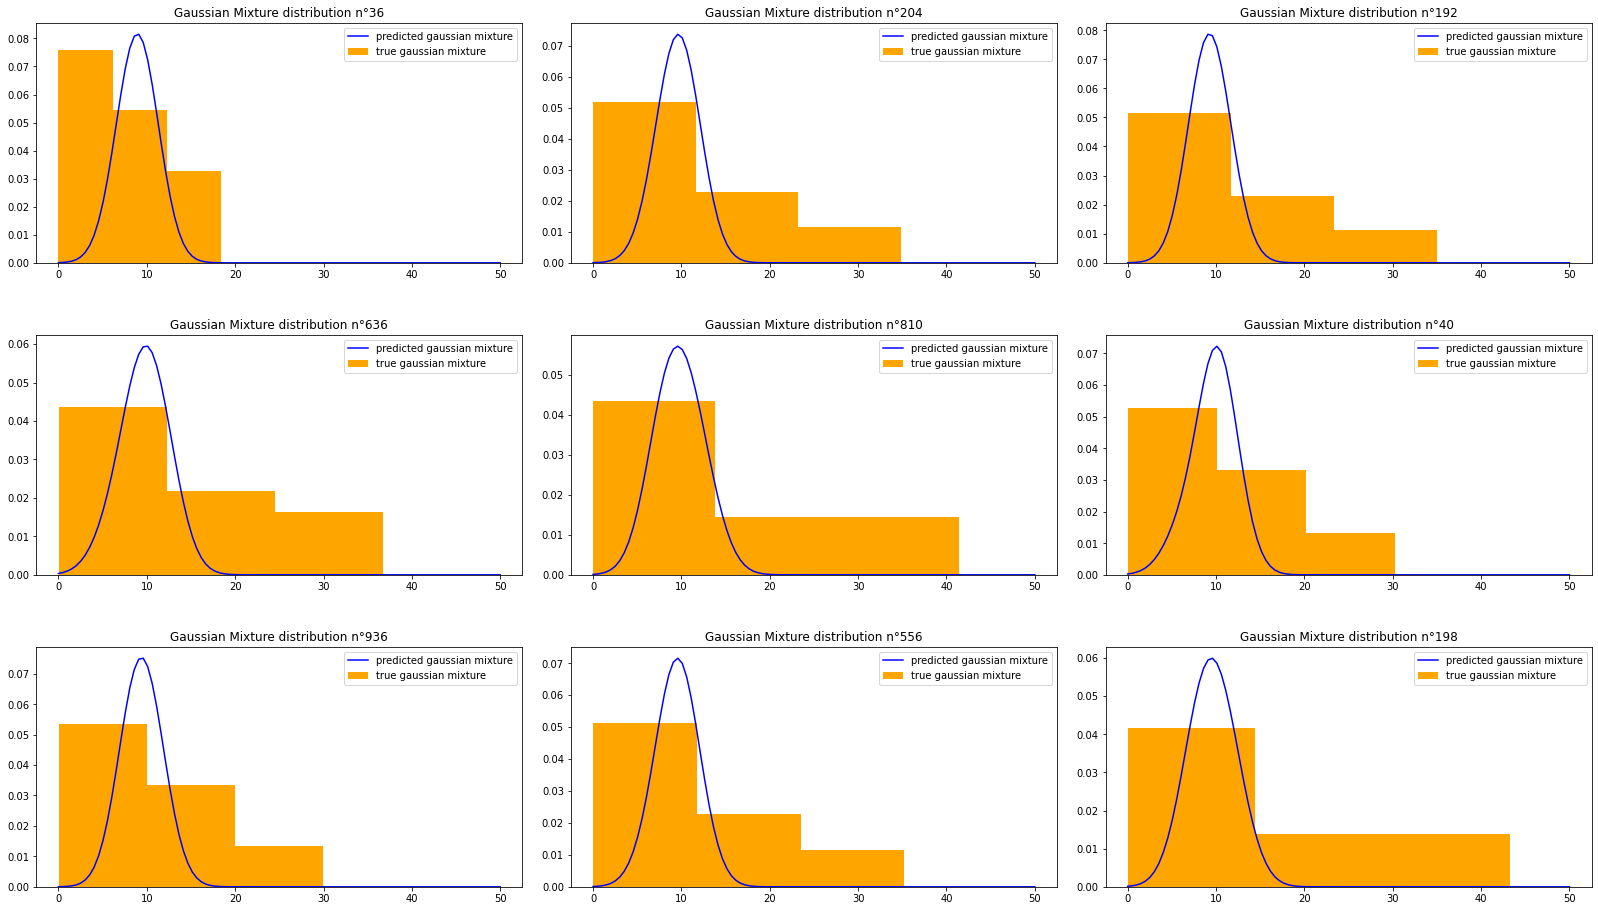

In [49]:
n_samples = 9
plot_pred_gaussian_mixture(y_val*50., y_pred, n_bins, n_samples, True)
#plot_pred_gaussian_mixture(y_val, y_pred_1, n_bins, n_samples, False, [i for i in range(0, n_samples)])